<a href="https://colab.research.google.com/github/Azimoj/Classifier-automatiquement-des-biens-de-consommation-NLP-IMAGE/blob/main/Copie_de_p6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The "Marketplace" company is launching an e-commerce marketplace where sellers offer items by posting a photo and description. Currently the categorization of the small number of products is done manually. The e-commerce site aims to expand and significantly increase the number of products, and manual categorization would be a long and unreliable step. To facilitate the posting of new articles and the search for products, it becomes necessary to automate this task. This categorization will be done from the descriptions and images of the products.

La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

### **Text Analysis**

https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
pip install "gensim==3.8.1"

     |████████████████████████████████| 24.2 MB 74.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# Corpus Processing
import nltk
nltk.download('stopwords')
import string
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import  RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk import SnowballStemmer,PorterStemmer
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


from sklearn.decomposition            import TruncatedSVD
from sklearn.decomposition            import NMF
from sklearn.decomposition            import LatentDirichletAllocation
from sklearn.decomposition            import PCA


from sklearn.metrics                  import confusion_matrix
from sklearn.metrics                  import homogeneity_score
from sklearn.metrics                  import silhouette_score
from sklearn.metrics                  import adjusted_rand_score

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import                                gensim
from gensim                           import corpora
from pprint                           import pprint
import                                gensim.downloader
from gensim                           import matutils, utils
from gensim.corpora                   import Dictionary

from gensim.models                    import CoherenceModel
from gensim.models                    import LdaModel
from gensim.models                    import TfidfModel


from gensim.models.basemodel          import BaseTopicModel
from gensim.models.nmf                import Nmf
from gensim.parsing.preprocessing     import preprocess_string
from operator                         import itemgetter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [ ]:
#Download databases
flipkart= pd.read_csv('/content/drive/MyDrive/p6/flipkart_com-ecommerce_sample_1050.csv',sep=',')
flipkart.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [ ]:
data =flipkart.copy()

In [ ]:
# supprimer les variables non pertinentes
data = data.drop(columns=['crawl_timestamp', 'product_url', 'pid',
                          'retail_price', 'discounted_price', 'is_FK_Advantage_product',
                          'product_rating', 'overall_rating', 'product_specifications',])

In [ ]:
# Vérification s'il y a des doublons dans uniq_id
data.duplicated(subset=['uniq_id']).any()

np.False_

In [ ]:
int(data['uniq_id'].duplicated().sum())

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   product_category_tree  1050 non-null   object
 3   image                  1050 non-null   object
 4   description            1050 non-null   object
 5   brand                  712 non-null    object
dtypes: object(6)
memory usage: 49.3+ KB


### **Missing values and imputation**

In [ ]:
import missingno as msno

<Axes: >

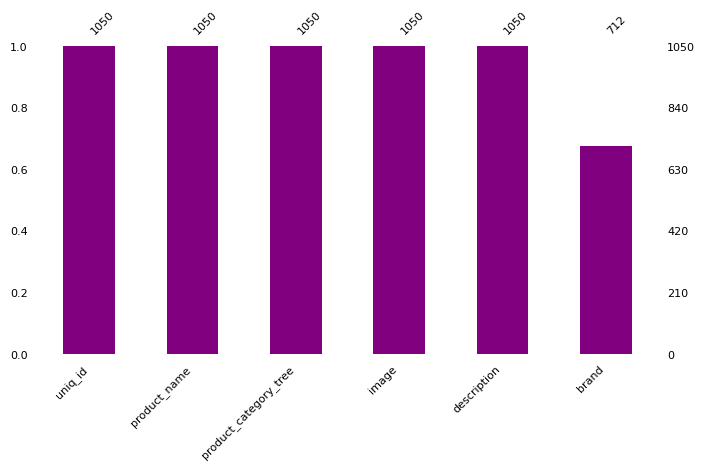

In [ ]:
msno.bar(data,  figsize=(8,4), fontsize = 8, color="purple")

In [ ]:
data.head(10)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   
5  893aa5ed55f7cff2eccea7758d7a86bd   
6  f355cc1ccb08bd0d283ed979b7ee7515   
7  dd0e3470a7e6ed76fd69c2da27721041   
8  41384da51732c0b4df3de8f395714fbb   
9  710ed5f2393a4b9e8823aa0029f71f93   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   
5  Maserati Time R8851116001 Analog Watch  - For ...   
6  Camerii WM64 Elegance Analog Watch  - For Men,...   
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys   
8  Alfajr WY16B Youth Digital Watch  - For Men, Boys   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
5  ["Watches >> Wrist Watches >> Maserati Time Wr...   
6  ["Watches >> Wrist Watches >> Camerii Wrist Wa...   
7  ["Watches >> Wrist Watches >> T STAR Wrist Wat...   
8  ["Watches >> Wrist Watches >> Alfajr Wrist Wat...   
9  ["Watches >> Wrist Watches >> TAG Heuer Wrist ...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
6  f355cc1ccb08bd0d283ed979b7ee7515.jpg   
7  dd0e3470a7e6ed76fd69c2da27721041.jpg   
8  41384da51732c0b4df3de8f395714fbb.jpg   
9  710ed5f2393a4b9e8823aa0029f71f93.jpg   

                                         description                  brand  
0  Key Features of Elegance Polyester Multicolor ...               Elegance  
1  Specifications of Sathiyas Cotton Bath Towel (...               Sathiyas  
2  Key Features of Eurospa Cotton Terry Face Towe...                Eurospa  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  SANTOSH ROYAL FASHION  
4  Key Features of Jaipur Print Cotton Floral Kin...           Jaipur Print  
5  Maserati Time R8851116001 Analog Watch  - For ...                    NaN  
6  Camerii WM64 Elegance Analog Watch  - For Men,...                    NaN  
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For B...                    NaN  
8  Alfajr WY16B Youth Digital Watch  - For Men, B...                    NaN  
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...                    NaN

In [ ]:
data.iloc[50:60]

uniq_id  \
50  69446af66066146718cd569f87e99fff   
51  b4d35b6536b623c83b293eb3a1c02bba   
52  f01140c02fd09e5c56312a64fa8db3da   
53  6329ddb46087cb8c09ced95471dd9643   
54  7e6ae1b372e8e0b509b83ba3658b8107   
55  e2ae2af58ac50adf4881751ae84a9d8a   
56  24e85c590481a7cedfe66597f253f2b2   
57  5e84d36ad6db970548498829db8b15de   
58  3c4604dba348a99a2dfbbc2cd3928101   
59  0abfcbe0e17dd50c4cf5fb1d6037d514   

                                         product_name  \
50                AKUP life-is-not-living Ceramic Mug   
51  RoQ Slim Multimedia 105key Flexible Wired USB ...   
52  Cookart Elegant S.S. Handi With Hot Pot Pack o...   
53  JRB 1038 Smallest Mobile Powered By OTG Enable...   
54  JRB 1033 Smallest Mobile Powered By OTG Enable...   
55  JRB 1042 Smallest Mobile Powered By OTG Enable...   
56        Borse N16 Make Up And Jewellery Vanity Case   
57  RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...   
58  RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...   
59  Brillare Science Dandruff Control Shampoo & In...   

                                product_category_tree  \
50  ["Kitchen & Dining >> Coffee Mugs >> AKUP Coff...   
51  ["Computers >> Tablet Accessories >> Keyboards...   
52  ["Kitchen & Dining >> Cookware >> Casserole & ...   
53  ["Computers >> Laptop Accessories >> USB Gadge...   
54  ["Computers >> Laptop Accessories >> USB Gadge...   
55  ["Computers >> Laptop Accessories >> USB Gadge...   
56  ["Beauty and Personal Care >> Makeup >> Vanity...   
57  ["Beauty and Personal Care >> Combos and Kits ...   
58  ["Beauty and Personal Care >> Combos and Kits ...   
59  ["Beauty and Personal Care >> Combos and Kits ...   

                                   image  \
50  69446af66066146718cd569f87e99fff.jpg   
51  b4d35b6536b623c83b293eb3a1c02bba.jpg   
52  f01140c02fd09e5c56312a64fa8db3da.jpg   
53  6329ddb46087cb8c09ced95471dd9643.jpg   
54  7e6ae1b372e8e0b509b83ba3658b8107.jpg   
55  e2ae2af58ac50adf4881751ae84a9d8a.jpg   
56  24e85c590481a7cedfe66597f253f2b2.jpg   
57  5e84d36ad6db970548498829db8b15de.jpg   
58  3c4604dba348a99a2dfbbc2cd3928101.jpg   
59  0abfcbe0e17dd50c4cf5fb1d6037d514.jpg   

                                          description             brand  
50  Key Features of AKUP life-is-not-living Cerami...              AKUP  
51  Key Features of RoQ Slim Multimedia 105key Fle...               RoQ  
52  Key Features of Cookart Elegant S.S. Handi Wit...           Cookart  
53  Key Features of JRB 1038 Smallest Mobile Power...               JRB  
54  Key Features of JRB 1033 Smallest Mobile Power...               JRB  
55  Key Features of JRB 1042 Smallest Mobile Power...               JRB  
56  Buy Borse N16 Make Up And Jewellery Vanity Cas...               NaN  
57  Specifications of RYTHMX FB NAIL POLISHES BLAC...            RYTHMX  
58  Key Features of RYTHMX FB NAIL POLISHES BLACK ...            RYTHMX  
59  Specifications of Brillare Science Dandruff Co...  Brillare Science

In [ ]:
# Remplacer chaque valeur manquante de brand par le premier mot de valeur correspondante de product_name

mask = data['brand'].isna()
data.loc[mask, 'brand'] = data.loc[mask, 'product_name'].str.split().str[0]


In [ ]:
data.iloc[5:10]

uniq_id  \
5  893aa5ed55f7cff2eccea7758d7a86bd   
6  f355cc1ccb08bd0d283ed979b7ee7515   
7  dd0e3470a7e6ed76fd69c2da27721041   
8  41384da51732c0b4df3de8f395714fbb   
9  710ed5f2393a4b9e8823aa0029f71f93   

                                        product_name  \
5  Maserati Time R8851116001 Analog Watch  - For ...   
6  Camerii WM64 Elegance Analog Watch  - For Men,...   
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys   
8  Alfajr WY16B Youth Digital Watch  - For Men, Boys   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   

                               product_category_tree  \
5  ["Watches >> Wrist Watches >> Maserati Time Wr...   
6  ["Watches >> Wrist Watches >> Camerii Wrist Wa...   
7  ["Watches >> Wrist Watches >> T STAR Wrist Wat...   
8  ["Watches >> Wrist Watches >> Alfajr Wrist Wat...   
9  ["Watches >> Wrist Watches >> TAG Heuer Wrist ...   

                                  image  \
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
6  f355cc1ccb08bd0d283ed979b7ee7515.jpg   
7  dd0e3470a7e6ed76fd69c2da27721041.jpg   
8  41384da51732c0b4df3de8f395714fbb.jpg   
9  710ed5f2393a4b9e8823aa0029f71f93.jpg   

                                         description     brand  
5  Maserati Time R8851116001 Analog Watch  - For ...  Maserati  
6  Camerii WM64 Elegance Analog Watch  - For Men,...   Camerii  
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For B...         T  
8  Alfajr WY16B Youth Digital Watch  - For Men, B...    Alfajr  
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...       TAG

## **Cleaning dataset & visualisation**

In [ ]:
data['product_name'].unique()

array(['Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
       'Sathiyas Cotton Bath Towel',
       'Eurospa Cotton Terry Face Towel Set', ...,
       'Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker',
       'Wallmantra Medium Vinyl Sticker Sticker',
       'Uberlyfe Large Vinyl Sticker'], dtype=object)

In [ ]:
data['product_name'].nunique()

1050

In [ ]:
data['product_category_tree'].sample(5)

421     ["Computers >> Network Components >> Routers >...
689     ["Kitchen & Dining >> Lighting >> Bulbs >> Phi...
878           ["Home Furnishing >> Bath Linen >> Towels"]
1018    ["Computers >> Laptop Accessories >> Computer ...
275     ["Baby Care >> Infant Wear >> Baby Boys' Cloth...
Name: product_category_tree, dtype: object

In [ ]:
data['description'].sample(5)

322    Flipkart.com: Buy Archies VJ-556 Combo Set onl...
422    Specifications of Clear Face Kesar Chandan Mul...
920    Buy Baby Bucket Cartoon Single Blanket blue at...
699    Buy Moonleaf Geometric Cushions Cover at Rs. 1...
902    Key Features of Prisha India Craft m_jug015-1-...
Name: description, dtype: object

**'product_category_tree'**

In [ ]:
data['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [ ]:
data['product_category_tree'][10]

'["Watches >> Wrist Watches >> Calibro Wrist Watches"]'

In [ ]:
# Extract and clean


# Clean the brackets and quotes
data['product_category_tree'] = data['product_category_tree'].str.strip('["]')

# Split into 3 columns, allowing for missing parts
split_columns = data['product_category_tree'].str.split('>>', n=2, expand=True)

# Remove extra whitespace from each level
split_columns = split_columns.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# Assign to new columns safely
data[['category_level_1', 'category_level_2', 'category_level_3']] = split_columns

# Clean level 1 category to remove internal spaces and special characters if needed
data['category_level_1'] = data['category_level_1'].str.replace(' ', '', regex=False)

# Map level 1 category to simplified category names
catg = {
    'HomeFurnishing': 'Home',
    'HomeDecor&FestiveNeeds': 'Decor',
    'Watches': 'Watches',
    'BabyCare': 'Baby',
    'BeautyandPersonalCare': 'Beauty',
    'Computers': 'Computers',
    'Kitchen&Dining': 'Kitchen'
}

data['category'] = data['category_level_1'].map(catg).fillna('Other')

# Encode simplified categories as numeric labels
cluster = {
    'Baby': 0,
    'Decor': 1,
    'Computers': 2,
    'Watches': 3,
    'Kitchen': 4,
    'Home': 5,
    'Beauty': 6,
    'Other': 7
}

data['label_category'] = data['category'].map(cluster)

In [ ]:
data.iloc[1:2]

uniq_id                product_name  \
1  7b72c92c2f6c40268628ec5f14c6d590  Sathiyas Cotton Bath Towel   

                                                                                                                   product_category_tree  \
1  Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...   

                                  image  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel   

      brand category_level_1  category_level_2  \
1  Sathiyas         BabyCare  Baby Bath & Skin   

                                                                                       category_level_3  \
1  Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...   

  category  label_category  
1     Baby               0

In [ ]:
data['category'].value_counts()

category
Home         150
Baby         150
Watches      150
Decor        150
Kitchen      150
Beauty       150
Computers    150
Name: count, dtype: int64

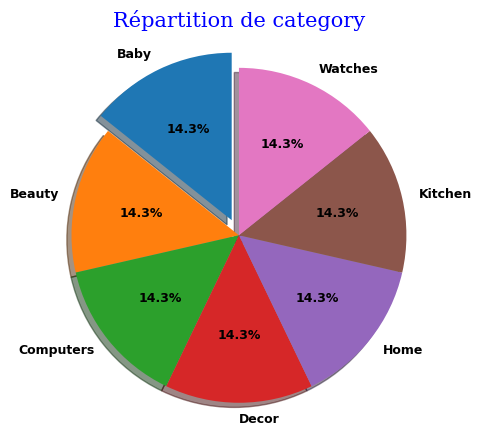

In [ ]:
#La répartition de category_1 :

category_1 = data.groupby(by='category')['uniq_id'].nunique().sort_values(ascending=False)

font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 15 }

explodes = np.zeros(7)
explodes[0] = .1
fig1, ax1 = plt.subplots(figsize = (5, 5))
ax1.pie(category_1, labels=category_1.index, explode=explodes, autopct='%1.1f%%',shadow=True, startangle=90,
       textprops=dict(color="black",size=9, weight="bold"))
ax1.axis('equal')
plt.title("Répartition de category", fontdict=font)
plt.show()

In [ ]:
# Check length of descriptions
data['description_length'] = data['description'].str.len()
data['description_length'].describe()

# Sample text
print(data['description'].iloc[0])


Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you 

In [ ]:
data['description_length'].describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description_length, dtype: float64

Usefulness in NLP/Text Analysis:

Helps you decide if you need to truncate or pad text for modeling.

Useful for tokenization limits (especially in models like TF-IDF, BERT, etc.).

You may want to normalize or filter out outliers (e.g., descriptions longer than 1000 characters) depending on your use case.

In [ ]:
data.drop('product_category_tree',inplace=True, axis=1)

In [ ]:
data.head(1)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   

      brand category_level_1        category_level_2  \
0  Elegance   HomeFurnishing  Curtains & Accessories   

                                                  category_level_3 category  \
0  Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...     Home   

   label_category  description_length  
0               5                1420

### **Text Preprocessing**

* remove punctional
* keep only alphabetic characters
* remove stopwords and isolated letters
* put all words in lowercase
* lemmatization
* keep only the canonical forms of words



In [ ]:
data['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

**Function for the number of words**

In [ ]:
df= data.copy()

In [ ]:
import re
import string
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.unit_keywords = ['cm', 'inch', 'inches', 'mm', 'kg', 'g', 'grams', 'ml', 'l', 'ft', 'm', 'pcs', 'pc']
        self.special_chars = ['±', '×', '+', '/', '\\', '*', 'x']

    def clean_text(self, text):
        if pd.isnull(text):
            return ""

        text = text.lower()

        # Remove unit patterns like "cm x cm"
        unit_pattern = '|'.join(self.unit_keywords)
        text = re.sub(rf'\b({unit_pattern})\s*[x×±+*/\\-]?\s*({unit_pattern})\b', '', text)

        # Remove digits + units (e.g., 50cm, 30inch)
        text = re.sub(rf'\b\d+\s*({unit_pattern})\b', '', text)

        # Remove alpha-numeric combos like 'shuvam20pcfts'
        text = re.sub(r'(\D+)\d+', r'\1', text)

        # Remove standalone numbers
        text = re.sub(r'\b\d+\b', '', text)

        # Remove special characters
        for char in self.special_chars:
            text = text.replace(char, ' ')

        # Remove punctuation
        text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)

        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        # Tokenize
        words = text.strip().split()

        # Remove stopwords
        words = [w for w in words if w not in self.stop_words]

        # Remove single-character words
        words = [w for w in words if len(w) > 1]

        # Lemmatize
        words = [self.lemmatizer.lemmatize(w) for w in words]

        return ' '.join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('text_cleaning', TextCleaner())
])

df['clean_description'] = pipeline.fit_transform(df['description'])

# View results
print(df[['description', 'clean_description']].head())


In [ ]:
df[['description', 'clean_description']].iloc[2:3]

description  \
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOWEL SET   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               clean_description  
2  key feature eurospa cotton terry face towel set size small height gsm eurospa cotton terry face towel set piece face towel set assorted price r eurospa brings clusively designed soft cotton towel port quality product soft te ture take care skin give enriched feeling deserve eurospa porting bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cm cm specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvampcftsetassorted ideal boy girl men woman model id shuvampcftsetassorted size small color assorted dimension weight length width bo number content sale package sale package piece face towel set

In [ ]:
df['clean_description_length'] = df['clean_description'].str.len()
df['clean_description_length'].describe()

count    1050.000000
mean      350.926667
std       327.408595
min        61.000000
25%       143.000000
50%       215.000000
75%       456.000000
max      2511.000000
Name: clean_description_length, dtype: float64

In [ ]:
df.to_csv('/content/drive/MyDrive/p6/cleaned_data.csv', index=False)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/p6/cleaned_data.csv')

In [ ]:
df.head(1)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   

      brand category_level_1        category_level_2  \
0  Elegance   HomeFurnishing  Curtains & Accessories   

                                                  category_level_3 category  \
0  Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...     Home   

   label_category  description_length  \
0               5                1420   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
df.columns

Index(['uniq_id', 'product_name', 'image', 'description', 'brand',
       'category_level_1', 'category_level_2', 'category_level_3', 'category',
       'label_category', 'description_length', 'clean_description',
       'clean_description_length'],
      dtype='object')

In [ ]:

# Import required modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  # or any classifier
from sklearn.model_selection import train_test_split, GridSearchCV


# Prepare features and labels
X = df['clean_description']  # raw text data
y = df['label_category']  #  target label (numeric category)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline = Pipeline([
    #('cleaner', TextCleaner()),  # your custom class
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=200))  # or try RandomForest, SVM, etc.
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=200))])

In [ ]:
y_pred = model_pipeline.predict(X_test)

In [ ]:
model = model_pipeline.named_steps['clf']


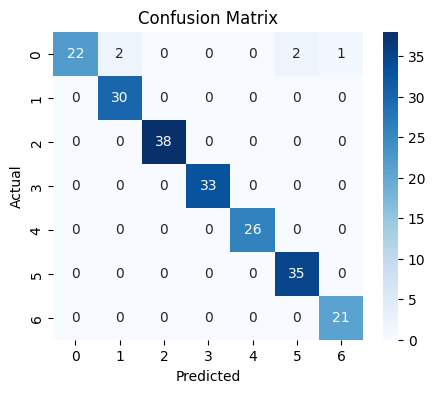

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        27
           1       0.94      1.00      0.97        30
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00        26
           5       0.95      1.00      0.97        35
           6       0.95      1.00      0.98        21

    accuracy                           0.98       210
   macro avg       0.98      0.97      0.97       210
weighted avg       0.98      0.98      0.98       210



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_pipeline.classes_,
            yticklabels=model_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
accuracy = model_pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.98


In [ ]:
param_grid = {
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'clf__C': 10, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Best Score: 0.9392857142857144


$\color{orange}{\text{3- Punctual words}}$

In [ ]:
def wordcloud(corpus):
  corpus_wordcloud = WordCloud().generate(corpus)
  plt.imshow(corpus_wordcloud)
  plt.axis('off')
  plt.show()

Texte original   Nombre de tokens: 67
--------------
specifications of sathiyas cotton bath towel    bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm    model name sathiyas cotton bath towel ideal for men women boys girls model id    color red yellow blue size mediam dimensions length    inch width    inch in the box number of contents in sales package    sales package    bath towel


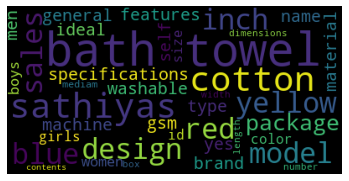

In [ ]:
# Paramètre
p_id = 1
content = data.loc[p_id,'description_clean']

prec, tokens_nb = ' ', 0
for char in content:
  tokens_nb += int(prec == ' ' and char != ' ')
  prec = char

process_step = 'Texte original'
print(process_step,'  Nombre de tokens:',tokens_nb)
print(len(process_step)*'-')
print(content)

wordcloud(content)

$\color{orange}{\text{4- Tokenize}}$


Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.


1.   Character tokens: s-m-a-r-t-e-r
2.   Subword tokens: smart-er
3.   Word tokenization:  Never-give-up

https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/

https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/

In [ ]:
def tokenization(text):
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  tokens=tokenizer.tokenize(text)
  return tokens

In [ ]:
# Tokenizing  texts.
from nltk.tokenize import word_tokenize
nltk.download('punkt')

data['description_tokenized'] = data["description_clean"].apply(lambda x: tokenization(x))
data['name_tokenized'] = data["name_clean"].apply(lambda x: tokenization(x))
display(data.sample(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


uniq_id                                 image  \
723  7c785e9e26092c0b6ed038085e90d89d  7c785e9e26092c0b6ed038085e90d89d.jpg   
852  70af4c3c05688d8400632e134f258b98  70af4c3c05688d8400632e134f258b98.jpg   

                                          product_name  \
723              House This Yellow 150 cm Table Runner   
852  Memore Portable and Flexible LED Light Lamp MM...   

                                           description   category  \
723  Buy House This Yellow 150 cm Table Runner at R...       Home   
852  Memore Portable and Flexible LED Light Lamp MM...  Computers   

     label_category           category_1  \
723               5  Kitchen&DiningLinen   
852               2    LaptopAccessories   

                                     description_clean  \
723  buy house this yellow    cm table runner at rs...   
852  memore portable and flexible led light lamp mm...   

                                            name_clean  \
723               house this yellow    cm table runner   
852  memore portable and flexible led light lamp mm...   

                                 description_tokenized  \
723  [buy, house, this, yellow, cm, table, runner, ...   
852  [memore, portable, and, flexible, led, light, ...   

                                        name_tokenized  
723           [house, this, yellow, cm, table, runner]  
852  [memore, portable, and, flexible, led, light, ...

In [ ]:
#test
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)
text_tokenized=data['description_tokenized'][idex]
print('#text tokenized#  :',text_tokenized)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : specifications of upside down sleeveless applique baby girls baby boys jacket general details ideal for baby girls baby boys pattern applique jacket details fabric poly cotton reversible no hooded no closure buttons sleeve sleeveless lining cotton fabric care do not wash with other garments hand wash with mild detergent do not tumble dry dry in shade additional details style code light pink smiley face jacket other details sleeveless in the box    jacket
#text tokenized#  : ['specifications', 'o

In [ ]:
size_f_Td=word_size(data,'description_tokenized')
print(size_f_Td)

5059


In [ ]:
size_f_Tn=word_size(data,'name_tokenized')
print(size_f_Tn)

1884


Tokenisation   Nombre de tokens: 67
------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


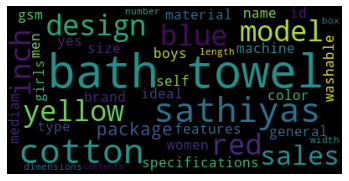

In [ ]:
process_step = 'Tokenisation'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_tokenized']))
print(len(process_step)*'-')

content = data['description_tokenized'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [ ]:
normalization_ = 1
if normalization_ == 1:
    # On normalise les valeurs de la variable temporaire 'content_clean'
    clean_2(data,'description_clean')

In [ ]:
tokens_list = []

# Tokenisation avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):
    # On tokenise les valeurs de la variale temporaire 'description_clean_1'
    # et on stocke les résultats dans une liste
    tokens_list.append(tokenizer.tokenize(data.loc[i,'description_clean']))

# On stocke les tokens dans une nouvelle variable 'content_tok_2'
data['description_clean_tok_2'] = tokens_list
# On supprime la variable temporaire 'content_clean'
#del data['description_clean_1']

data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  
0  [key, features, of, elegance, polyester, multi...  
1  [specifications, of, sathiyas, cotton, bath, t...

In [ ]:
size_filtre4=word_size(data,'description_clean_tok_2')
print(size_filtre4)

5053


Tokenisation2   Nombre de tokens: 67
-------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


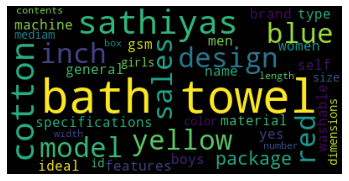

In [ ]:
process_step = 'Tokenisation2'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_clean_tok_2']))
print(len(process_step)*'-')

content = data['description_clean_tok_2'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{5- Stop words}}$

In [ ]:
stopword=nltk.corpus.stopwords.words('english')

In [ ]:
def remove_sw(text):
  text=[word for word in text if word not in stopword]
  return text

In [ ]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords


data['description_stopword'] = data['description_tokenized'].apply(lambda x: remove_sw(x))
data['name_stopword'] = data['name_tokenized'].apply(lambda x: remove_sw(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stopword'][idex]
print('#text without stopwords#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
size_filtre4=word_size(data,'description_stopword')
print(size_filtre4)

4945


In [ ]:
size_filtre4=word_size(data,'name_stopword')
print(size_filtre4)

1841


stopword   Nombre de stop word: 61
--------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


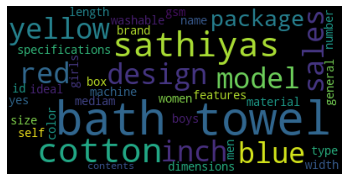

In [ ]:
process_step = 'stopword'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_stopword']))
print(len(process_step)*'-')

content = data['description_stopword'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- 2nd stop words}}$

Deleting the words which has just one letter

In [ ]:
def rem_short_words(words_list, char_len = 2):
    word_len = [len(i) for i in words_list]
    index_keep = np.array(word_len) > char_len
    words_list_red = np.array(words_list)[index_keep]
    return(list(words_list_red))

In [ ]:
from nltk.corpus import stopwords
stop_words_0 = stopwords.words('english')
print('Nombre de stop words (base nltk):',len(stop_words_0))

Nombre de stop words (base nltk): 179


In [ ]:
data['description_stw']=data['description_stopword'].apply(rem_short_words)
data['name_stw']=data['name_stopword'].apply(rem_short_words)

In [ ]:
word_size(data,'description_stw')

4867

In [ ]:
word_size(data,'name_stw')

1793

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stw'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

2nd stopword   Nombre de stw: 60
------------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


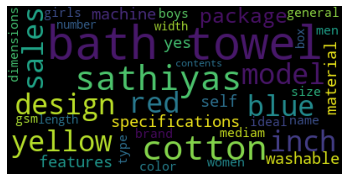

In [ ]:
process_step = '2nd stopword'
print(process_step,'  Nombre de stw:',len(data.loc[p_id,'description_stw']))
print(len(process_step)*'-')

content = data['description_stw'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- POS tagging}}$

is a task of labelling each word in a sentence with its appropriate ***part of speech***. We already know that parts of speech include nouns, verb, adverbs, adjectives, pronouns, conjunction and their sub-categories.

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

data['description_pos_tags'] = data['description_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data['name_pos_tags'] = data['name_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data.head(2)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                description_pos_tags  \
0  [JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...   
1  [NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...   

                  name_pos_tags  
0  [NN, NN, NN, JJ, NN, NN, NN]  
1              [JJ, NN, NN, NN]

In [ ]:
data['description_pos_tags_sentence'] = data['description_pos_tags'].apply(lambda x: ' '.join(x))
data['name_pos_tags_sentence'] = data['name_pos_tags'].apply(lambda x: ' '.join(x))
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                description_pos_tags  \
0  [JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...   
1  [NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...   

                  name_pos_tags  \
0  [NN, NN, NN, JJ, NN, NN, NN]   
1              [JJ, NN, NN, NN]   

                       description_pos_tags_sentence name_pos_tags_sentence  
0  JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...   NN NN NN JJ NN NN NN  
1  NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...            JJ NN NN NN

In [ ]:
#removes adverbe
adjective_tag_list = ['V','JJ','RB','JJR', 'JJS', 'RBR', 'RBS'] # List of Adjective's,Verbe's tag from nltk package

def remove_adv(text):
  nltk_tokens = nltk.word_tokenize(text)
  corpus  = [word for word, pos in nltk.pos_tag(nltk_tokens) if not  pos in adjective_tag_list] # Select all words that don't have the undesired tags
  return   ' '.join(map(str, corpus))

In [ ]:
data['description_adv']=data['description_pos_tags_sentence'].apply(lambda x: remove_adv(x))
data["name_adv"] = data["name_pos_tags_sentence"].apply(lambda x: remove_adv(x))

In [ ]:

#test
text=data.description_pos_tags_sentence[idex]
print('#text originale#:',text)
text_modifier=data['description_adv'][idex]
print('#text modifié#  :',text_modifier)

#text originale#: JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN
#text modifié#  : JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN


In [ ]:
word_size(data,'description_adv')

27

In [ ]:
word_size(data,'name_adv')

25

In [ ]:
data['name_adv'].nunique()

591

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


list_of_verbs = []
for i in range(len(description_pos_tags)):
if description_pos_tags[i][18].startswith('V') :
list_of_verbs.append(description_pos_tags[i][18])

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(list_of_verbs)

IndentationError: ignored

### **Reducing the words**
* Stemming
* Lemmatization

$\color{orange}{\text{6- Lemmatization}}$

The real difference between stemming and lemmatization is that Stemming reduces word-forms to (pseudo)stems which might be meaningful or meaningless, whereas lemmatization reduces the word-forms to linguistically valid meaning.

In [ ]:
import nltk
nltk.download('wordnet')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
data['description_lemma']=data['description_stw'].apply(lambda x : lemmatize_text(x))
data['name_lemma']=data['name_stw'].apply(lambda x : lemmatize_text(x))

In [ ]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_lemma'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [ ]:
word_size(data,'description_lemma')

4460

In [ ]:
word_size(data,'name_lemma')

1746

description_lemma   Nombre de stop word: 60
-----------------
specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men woman boy girl model color red yellow blue size mediam dimension length inch width inch box number content sale package sale package bath towel


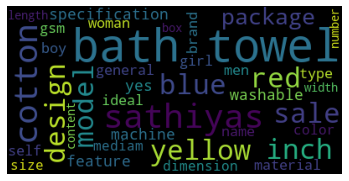

In [ ]:
process_step = 'description_lemma'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_lemma']))
print(len(process_step)*'-')

content = data['description_lemma'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{7- Stemming}}$

In [ ]:
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                description_pos_tags  \
0  [JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...   
1  [NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...   

                  name_pos_tags  \
0  [NN, NN, NN, JJ, NN, NN, NN]   
1              [JJ, NN, NN, NN]   

                       description_pos_tags_sentence name_pos_tags_sentence  \
0  JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...   NN NN NN JJ NN NN NN   
1  NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...            JJ NN NN NN   

                                   description_lemma  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                          name_lemma  
0  [elegance, polyester, multicolor, abstract, ey...  
1                    [sathiyas, cotton, bath, towel]

In [ ]:
from nltk.stem.snowball import EnglishStemmer
stemm=EnglishStemmer()

def stem_word(text):
  stem_text=[stemm.stem(word)for word in text]
  return stem_text


In [ ]:
data['description_stem'] = data['description_lemma'].apply(lambda x: stem_word(x))
data['name_stem'] = data['name_lemma'].apply(lambda x: stem_word(x))

In [ ]:
#test
text=data.description_lemma[idex]
print('#text originale#:',text)
text_modifier=data['description_stem'][idex]
print('#text modifié#  :',text_modifier)

#text originale#: ['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'soft

In [ ]:
word_size(data,'description_stem')

3877

supprimer les mots courts

In [ ]:
data["description_short"] = data["description_stem"].apply(lambda x: rem_short_words(x))
data["name_short"] = data["name_stem"].apply(lambda x: rem_short_words(x))

In [ ]:
word_size(data,'description_short')

3863

In [ ]:
word_size(data,'name_short')

1700

stemming   Nombre de tonek: 60
--------
specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl yes materi cotton design self design general brand sathiya type bath towel gsm model name sathiya cotton bath towel ideal men woman boy girl model color red yellow blue size mediam dimens length inch width inch box number content sale packag sale packag bath towel


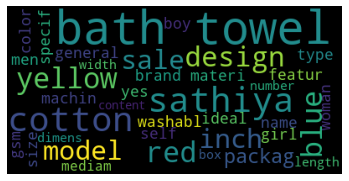

In [ ]:
process_step = 'stemming'
print(process_step,'  Nombre de tonek:',len(data.loc[p_id,'description_short']))
print(len(process_step)*'-')

content = data['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

### **Frequency calculation**

Term frequency answers the question of, how many times does this word appear in this document, how important is this word to this specific document.

The re. compile() method:

With this method we can combine a regular expression pattern into pattern objects, which can be used for pattern matching. It also helps to search a pattern again without rewriting it

In [ ]:
# http://pymotw.com/2/re/

import re
#import the regular expressions

corpus=data['description_stem']
words_dico=dict()

expr =re.compile("\W+",re.U) #  method is used to compile a regular expression pattern provided as a string into a regex pattern object (re.Pattern)
for text in corpus:           # re.U. Interprets letters according to the Unicode character set. This flag affects the behavior of \w, \W, \b, \B. 6.
  text = str(text)
  text = expr.split(text)
  for word in set(text):
    if word not in words_dico:
      words_dico[word]=1
    else:
          words_dico[word]=words_dico[word]+1



In [ ]:
len(words_dico)

3877

**Frequency exploration**

In [ ]:
df_word_freq=pd.DataFrame({'words':words_dico.keys(),'Frequency':words_dico.values()})

In [ ]:
df=df_word_freq.sort_values(ascending=False,by='Frequency')
df.head()

words  Frequency
0                   1050
148   product        667
212      free        594
206       buy        576
205  deliveri        566

**Droping all the space**

In [ ]:
df_word_freq.drop([0],inplace=True, axis=0)

In [ ]:
df_word_freq.sort_values(ascending=False,by='Frequency').head()

words  Frequency
148   product        667
212      free        594
206       buy        576
205  deliveri        566
199      ship        565

Text(0.5, 1.0, 'Frequency of words')

<Figure size 1440x720 with 0 Axes>

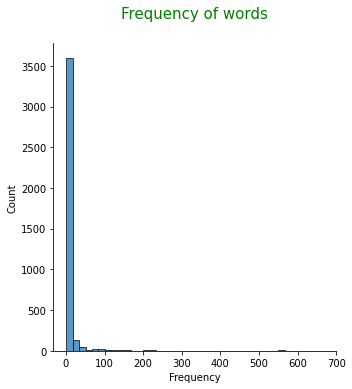

In [ ]:
plt.figure(figsize=(20,10))
sns.displot(data=df_word_freq,bins=40, x="Frequency");
plt.title('Frequency of words', fontsize = 15, pad = 25, color='green')

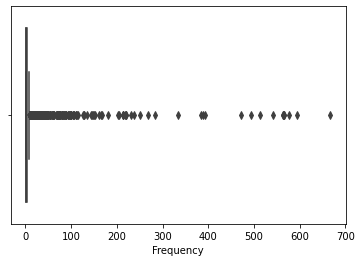

In [ ]:
sns.boxplot(data=df_word_freq,x='Frequency');

In [ ]:
df_word_freq['Frequency'].describe()

count    3876.000000
mean        8.394479
std        37.071738
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       667.000000
Name: Frequency, dtype: float64

In [ ]:
sorted_freq=df_word_freq.sort_values(by='Frequency',ascending=False)

In [ ]:
df1=sorted_freq[0:40]

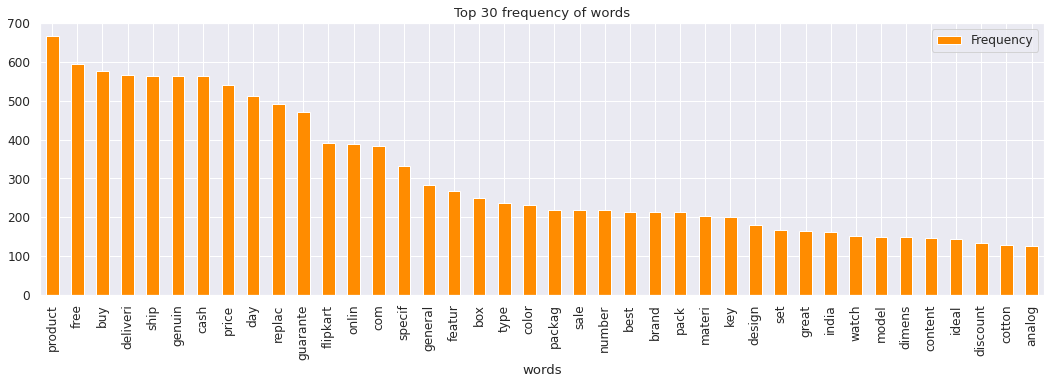

In [ ]:

sns.set(font_scale=1.1)
df1.plot(kind='bar',x='words',y='Frequency',title='Top 30 frequency of words',figsize=(18,5) ,color="darkorange")

In [ ]:
df2=sorted_freq[-41:-1]

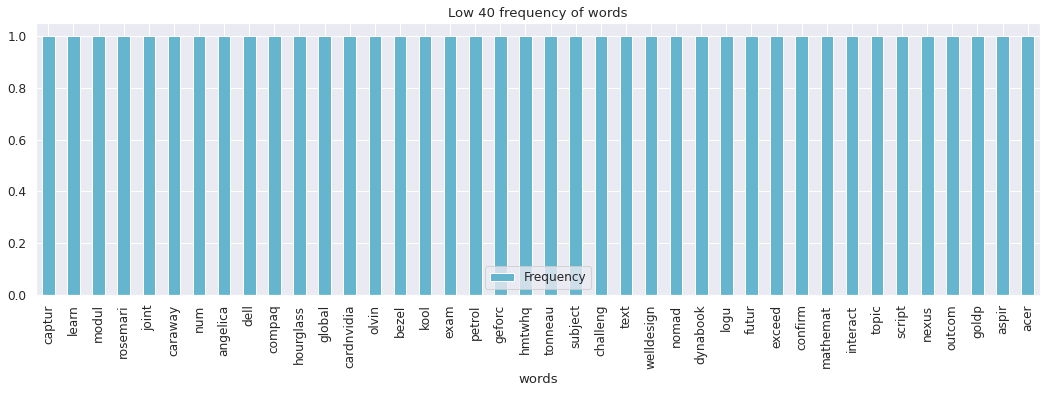

In [ ]:
df2.plot(kind='bar',x='words',y='Frequency', color="c",figsize=(18,5),title='Low 40 frequency of words')

In [ ]:
len(sorted_freq)

3876

**Filtering dataset**

In [ ]:
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                   description_lemma  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                          name_lemma  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                    description_stem  \
0  [key, featur, eleg, polyest, multicolor, abstr...   
1  [specif, sathiya, cotton, bath, towel, bath, t...   

                                           name_stem  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1                     [sathiya, cotton, bath, towel]   

                                   description_short  \
0  [key, featur, eleg, polyest, multicolor, abstr...   
1  [specif, sathiya, cotton, bath, towel, bath, t...   

                                          name_short  
0  [eleg, polyest, multicolor, abstract, eyelet, ...  
1                     [sathiya, cotton, bath, towel]

In [ ]:
print(len(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1]),"words are repeated once")

2012 words are repeated once


In [ ]:
rem_list = list(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1])
df_word_freq['words'][rem_list].values

array(['modernist', 'appar', 'valanc', ..., 'decalstick', 'film',
       'polyvinyl'], dtype=object)

In [ ]:
data['final'] = data['description_short']
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  key features of elegance polyester multicolor ...   
1         BabyBath&Skin  specifications of sathiyas cotton bath towel b...   

                                          name_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1                         sathiyas cotton bath towel   

                               description_tokenized  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                      name_tokenized  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                   description_lemma  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                          name_lemma  \
0  [elegance, polyester, multicolor, abstract, ey...   
1                    [sathiyas, cotton, bath, towel]   

                                    description_stem  \
0  [key, featur, eleg, polyest, multicolor, abstr...   
1  [specif, sathiya, cotton, bath, towel, bath, t...   

                                           name_stem  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1                     [sathiya, cotton, bath, towel]   

                                   description_short  \
0  [key, featur, eleg, polyest, multicolor, abstr...   
1  [specif, sathiya, cotton, bath, towel, bath, t...   

                                          name_short  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1                     [sathiya, cotton, bath, towel]   

                                               final  
0  [key, featur, eleg, polyest, multicolor, abstr...  
1  [specif, sathiya, cotton, bath, towel, bath, t...

## **Bag of words**

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.

In [ ]:
data.keys()

Index(['uniq_id', 'image', 'product_name', 'description', 'category',
       'label_category', 'category_1', 'description_clean', 'name_clean',
       'description_tokenized', 'name_tokenized', 'description_clean_tok_2',
       'description_stopword', 'name_stopword', 'description_stw', 'name_stw',
       'description_lemma', 'name_lemma', 'description_stem', 'name_stem',
       'description_short', 'name_short', 'final'],
      dtype='object')

In [ ]:
data['description_short_']= data['description_short'].apply(lambda x: ' '.join(x))
data['name_short_']= data['name_short'].apply(lambda x: ' '.join(x))

In [ ]:
#vectorize
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer_1=CountVectorizer( min_df = 0.01, stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=(1,1))
tf_matrix_1 = tf_vectorizer_1.fit_transform(data['description_short_'])

In [ ]:
features_names=tf_vectorizer_1.get_feature_names()
#dense=X.todense()
#denselist=dense.tolist()
#word_fre_vect=pd.DataFrame(denselist,columns=features_names)
word_fre_vect_uni=pd.DataFrame(tf_matrix_1.toarray(),columns=tf_vectorizer_1.get_feature_names())
word_fre_vect_uni.head(3)

abstract  accessori  actual  adapt  add  addit  ador  afford  age  \
0         4          0       0      0    0      0     0       0    0   
1         0          0       0      0    0      0     0       0    0   
2         0          0       0      0    0      0     0       0    0   

   aluminium  analog  antiqu  appeal  appl  appli  area  aroma  art  artist  \
0          0       0       0       1     0      0     0      0    0       0   
1          0       0       0       0     0      0     0      0    0       0   
2          0       0       0       0     0      0     0      0    0       0   

   assur  attract  authent  avail  babi  bag  base  bath  batteri  beauti  \
0      0        0        0      0     0    0     0     0        0       1   
1      0        0        0      0     0    0     0     6        0       0   
2      0        0        0      0     0    0     0     2        0       0   

   bed  bedroom  bedsheet  best  black  blanket  bleach  blue  bodi  bottl  \
0    0        0         0     0      0        0       0     0     1      0   
1    0        0         0     0      0        0       0     2     0      0   
2    0        0         0     0      0        0       1     0     0      0   

   box  boy  brand  brass  break  bring  broadcast  brown  buckl  bulb  \
0    1    0      1      0      0      1          0      0      0     0   
1    1    1      1      0      0      0          0      0      0     0   
2    1    1      2      0      0      1          0      0      0     0   

   button  buy  cabl  capac  care  carri  case  cash  casual  catchi  cell  \
0       0    0     0      0     0      0     0     0       0       0     0   
1       0    0     0      0     0      0     0     0       0       0     0   
2       0    0     0      0     2      0     0     0       0       0     0   

   ceram  certif  charger  check  checker  cheer  clasp  classic  clean  \
0      0       0        0      0        0      0      0        0      0   
1      0       0        0      0        0      0      0        0      0   
2      0       0        0      0        0      0      0        0      0   

   clear  closur  cloth  code  coffe  coffeetea  cold  collect  color  colour  \
0      0       0      0     0      0          0     0        0      1       0   
1      0       0      0     0      0          0     0        0      1       0   
2      0       0      0     0      0          0     1        0      2       0   

   com  combin  combo  come  comfort  compat  complet  consumpt  contain  \
0    0       0      0     0        0       0        0         0        0   
1    0       0      0     0        0       0        0         0        0   
2    0       0      0     0        0       0        0         0        0   

   contemporari  content  cor  cotton  cover  craft  cream  creation  cupcak  \
0             1        1    0       0      0      0      0         0       0   
1             0        1    0       3      0      0      0         0       0   
2             0        1    0       6      0      0      0         0       0   

   curtain  cushion  custom  cute  damag  dark  day  decor  defect  deliveri  \
0       11        0       0     0      0     0    0      0       0         0   
1        0        0       0     0      0     0    0      0       0         0   
2        0        0       0     0      0     0    0      0       0         0   

   depth  design  deterg  devic  dial  diamet  differ  digit  dimens  \
0      0       3       0      0     0       0       0      0       1   
1      0       2       0      0     0       0       0      0       1   
2      0       2       0      0     0       0       0      0       1   

   disclaim  discount  display  distinct  door  doubl  dress  dri  durabl  \
0         0         0        0         0     5      0      0    0       0   
1         0         0        0         0     0      0      0    0       0   
2         0         0        0         0     0      0      0    1       

In [ ]:
word_fre_vect_uni.shape

(1050, 452)

In [ ]:
df=pd.DataFrame({'Word frequancy': word_fre_vect_uni.max().sort_values(ascending=False).index,'Total':word_fre_vect_uni.max().sort_values(ascending=False).values})

In [ ]:
df

Word frequancy  Total
0          product     21
1           laptop     21
2          blanket     19
3            towel     18
4             skin     18
..             ...    ...
447           cash      1
448         genuin      1
449    suitablefor      1
450        summari      1
451         lowest      1

[452 rows x 2 columns]

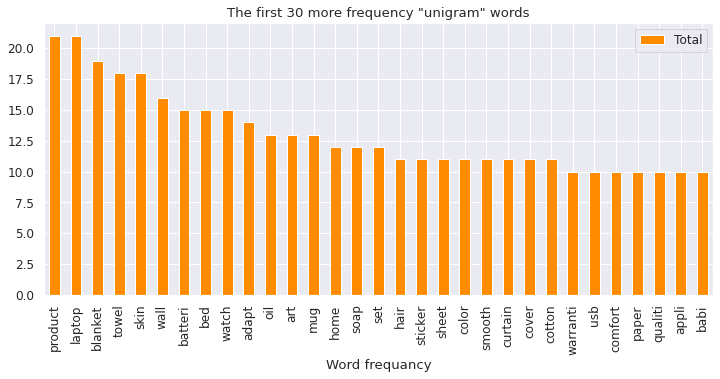

In [ ]:

df1=df.loc[0:30,['Word frequancy','Total']]

df1.plot(kind='bar',x='Word frequancy',y='Total', color="darkorange",title='The first 30 more frequency "unigram" words',figsize=(12,5))


In [ ]:
tf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tf_matrix_2 = tf_vectorizer_2.fit_transform(data['description_short_'])

In [ ]:
features_names=tf_vectorizer_2.get_feature_names()
word_fre_vect_bi=pd.DataFrame(tf_matrix_2.toarray(),columns=tf_vectorizer_2.get_feature_names())

In [ ]:
df_v2=pd.DataFrame({'Word frequancy': word_fre_vect_bi.max().sort_values(ascending=False).index,'Total':word_fre_vect_bi.max().sort_values(ascending=False).values})

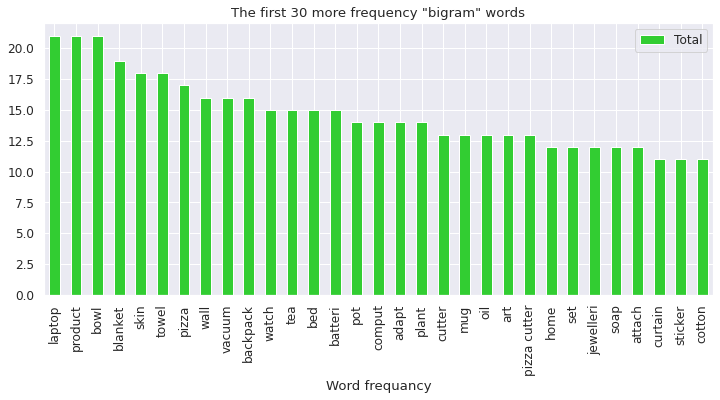

In [ ]:
df2=df_v2.loc[0:30,['Word frequancy','Total']]

df2.plot(kind='bar',x='Word frequancy',y='Total', color="limegreen",title='The first 30 more frequency "bigram" words',figsize=(12,5))

### **TF IDF**
Term frequency-inverse document frequency

Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.
tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification. One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
# unigrams
tfidf_vectorizer_1 = TfidfVectorizer( min_df = 0.01, stop_words = 'english', analyzer="word", token_pattern=r'\w+')
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(data['description_short_'])


In [ ]:
features_names=tfidf_vectorizer_1.get_feature_names()
dense=tfidf_matrix_1.todense()
denselist=dense.tolist()
words_freq_1=pd.DataFrame(denselist,columns=features_names)
words_freq_1.head(3)

abstract  accessori  actual  adapt  add  addit  ador  afford  age  \
0  0.193004        0.0     0.0    0.0  0.0    0.0   0.0     0.0  0.0   
1  0.000000        0.0     0.0    0.0  0.0    0.0   0.0     0.0  0.0   
2  0.000000        0.0     0.0    0.0  0.0    0.0   0.0     0.0  0.0   

   aluminium  analog  antiqu    appeal  appl  appli  area  aroma  art  artist  \
0        0.0     0.0     0.0  0.063616   0.0    0.0   0.0    0.0  0.0     0.0   
1        0.0     0.0     0.0  0.000000   0.0    0.0   0.0    0.0  0.0     0.0   
2        0.0     0.0     0.0  0.000000   0.0    0.0   0.0    0.0  0.0     0.0   

   assur  attract  authent  avail  babi  bag  base      bath  batteri  \
0    0.0      0.0      0.0    0.0   0.0  0.0   0.0  0.000000      0.0   
1    0.0      0.0      0.0    0.0   0.0  0.0   0.0  0.581789      0.0   
2    0.0      0.0      0.0    0.0   0.0  0.0   0.0  0.111082      0.0   

     beauti  bed  bedroom  bedsheet  best  black  blanket    bleach      blue  \
0  0.043115  0.0      0.0       0.0   0.0    0.0      0.0  0.000000  0.000000   
1  0.000000  0.0      0.0       0.0   0.0    0.0      0.0  0.000000  0.164427   
2  0.000000  0.0      0.0       0.0   0.0    0.0      0.0  0.053318  0.000000   

       bodi  bottl       box       boy     brand  brass  break     bring  \
0  0.043115    0.0  0.028225  0.000000  0.030071    0.0    0.0  0.049915   
1  0.000000    0.0  0.051673  0.073823  0.055052    0.0    0.0  0.000000   
2  0.000000    0.0  0.029598  0.042285  0.063067    0.0    0.0  0.052343   

   broadcast  brown  buckl  bulb  button  buy  cabl  capac      care  carri  \
0        0.0    0.0    0.0   0.0     0.0  0.0   0.0    0.0  0.000000    0.0   
1        0.0    0.0    0.0   0.0     0.0  0.0   0.0    0.0  0.000000    0.0   
2        0.0    0.0    0.0   0.0     0.0  0.0   0.0    0.0  0.081729    0.0   

   case  cash  casual  catchi  cell  ceram  certif  charger  check  checker  \
0   0.0   0.0     0.0     0.0   0.0    0.0     0.0      0.0    0.0      0.0   
1   0.0   0.0     0.0     0.0   0.0    0.0     0.0      0.0    0.0      0.0   
2   0.0   0.0     0.0     0.0   0.0    0.0     0.0      0.0    0.0      0.0   

   cheer  clasp  classic  clean  clear  closur  cloth  code  coffe  coffeetea  \
0    0.0    0.0      0.0    0.0    0.0     0.0    0.0   0.0    0.0        0.0   
1    0.0    0.0      0.0    0.0    0.0     0.0    0.0   0.0    0.0        0.0   
2    0.0    0.0      0.0    0.0    0.0     0.0    0.0   0.0    0.0        0.0   

      cold  collect     color  colour  com  combin  combo  come  comfort  \
0  0.00000      0.0  0.029136     0.0  0.0     0.0    0.0   0.0      0.0   
1  0.00000      0.0  0.053341     0.0  0.0     0.0    0.0   0.0      0.0   
2  0.06399      0.0  0.061107     0.0  0.0     0.0    0.0   0.0      0.0   

   compat  complet  consumpt  contain  contemporari   content  cor    cotton  \
0     0.0      0.0       0.0      0.0      0.062685  0.034490  0.0  0.000000   
1     0.0      0.0       0.0      0.0      0.000000  0.063144  0.0  0.197770   
2     0.0      0.0       0.0      0.0      0.000000  0.036168  0.0  0.226563   

   cover  craft  cream  creation  cupcak   curtain  cushion  custom  cute  \
0    0.0    0.0    0.0       0.0     0.0  0.622267      0.0     0.0   0.0   
1    0.0    0.0    0.0       0.0     0.0  0.000000      0.0     0.0   0.0   
2    0.0    0.0    0.0       0.0     0.0  0.000000      0.0     0.0   0.0   

   damag  dark  day  decor  defect  deliveri  depth    design  deterg  devic  \
0    0.0   0.0  0.0    0.0     0.0       0.0    0.0  0.096215     0.0    0.0   
1    0.0   0.0  0.0    0.0     0.0       0.0    0.0  0.117431     0.0    0.0   
2    0.0   0.0  0.0    0.0     0.0       0.0    0.0  0.067264     0.0    0.0   

   dial  diamet  differ  digit    dimens  disclaim  discount  display  \
0   0.0     0.0     0.0    0.0  0.034333       0.0       0.0      0.0   
1   0.0     0.0     0.0    0.0  0.062856       0.0       0.0      0.0   
2   0.0     0.0     0.0    0.0  

In [ ]:
words_freq_1.shape

(1050, 452)

In [ ]:
df=pd.DataFrame({'word_freq': words_freq_1.max().sort_values(ascending=False).index,'Total':words_freq_1.max().sort_values(ascending=False).values})

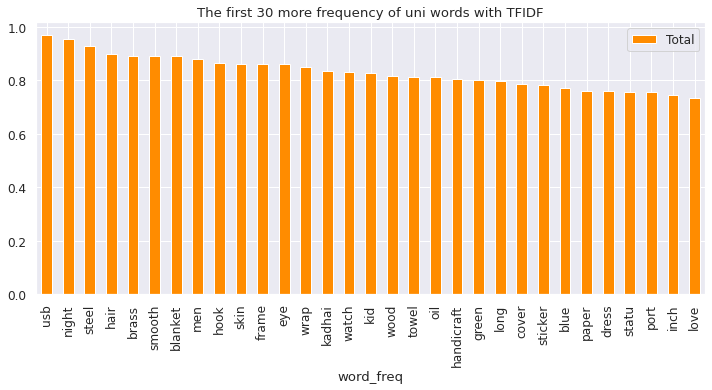

In [ ]:
df1=df.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents
df1.plot(kind='bar',x='word_freq',y='Total', color="darkorange",title='The first 30 more frequency of uni words with TFIDF',figsize=(12,5))

In [ ]:
# unigram & bigrams
tfidf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(data['description_short_'])

In [ ]:
features_names=tf_vectorizer_2.get_feature_names()
dense=tf_matrix_2.todense()
denselist=dense.tolist()
words_freq_2=pd.DataFrame(denselist,columns=features_names)
words_freq_2.head(3)

aapno  aapno rajasthan  abil  abl  abl light  abod  absorb  abstract  \
0      0                0     0    0          0     0       0         4   
1      0                0     0    0          0     0       0         0   
2      0                0     0    0          0     0       1         0   

   abstract art  abstract ceram  abstract cushion  abstract design  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   

   abstract doubl  abstract eyelet  abstract floral  abstract singl  accent  \
0               0                3                0               0       0   
1               0                0                0               0       0   
2               0                0                0               0       0   

   access  accessori  accessori batteri  accid  accident  accident damag  \
0       0          0                  0      0         0               0   
1       0          0                  0      0         0               0   
2       0          0                  0      0         0               0   

   accord  ach  across  across world  act  actual  actual product  adapt  \
0       0    0       0             0    0       0               0      0   
1       0    0       0             0    0       0               0      0   
2       0    0       0             0    0       0               0      0   

   adapt also  adapt charger  adapt come  adapt conform  adapt design  \
0           0              0           0              0             0   
1           0              0           0              0             0   
2           0              0           0              0             0   

   adapt equip  adapt general  adapt key  adapt laptop  adapt model  \
0            0              0          0             0            0   
1            0              0          0             0            0   
2            0              0          0             0            0   

   adapt output  adapt pin  adapt pleas  adapt power  adapt price  \
0             0          0            0            0            0   
1             0          0            0            0            0   
2             0          0            0            0            0   

   adapt voltag  adaptor  adaptor usb  add  add eleg  add kitchen  \
0             0        0            0    0         0            0   
1             0        0            0    0         0            0   
2             0        0            0    0         0            0   

   add perfect  add spunk  add touch  addit  addit detail  addit featur  \
0            0          0          0      0             0             0   
1            0          0          0      0             0             0   
2            0          0          0      0             0             0   

   addit kitchen  addit trait  adhes  adhes pvc  adhes sticker  adida  \
0              0            0      0          0              0      0   
1              0            0      0          0              0      0   
2              0            0      0          0              0      0   

   adida ice  adjust  adjust shoulder  admir  admir guest  ador  ador fantast  \
0          0       0                0      0            0     0             0   
1          0       0                0      0            0     0             0   
2          0       0                0      0            0     0             0   

   adorn  adsl  adsl modem  advic  advic inadvert  aero  aero care  affect  \
0      0     0           0      0               0     0          0       0   
1      0     0           0      0               0     0          0       0   
2      0     0           0      0               0     0          0       0   

   affect antiag  afford  afford art  afford mug  age  age group  aid  air  \
0              0       0           0           0    

In [ ]:
words_freq_2.shape

(1050, 5651)

In [ ]:
df_2=pd.DataFrame({'word_freq': words_freq_2.max().sort_values(ascending=False).index,'Total':words_freq_2.max().sort_values(ascending=False).values})


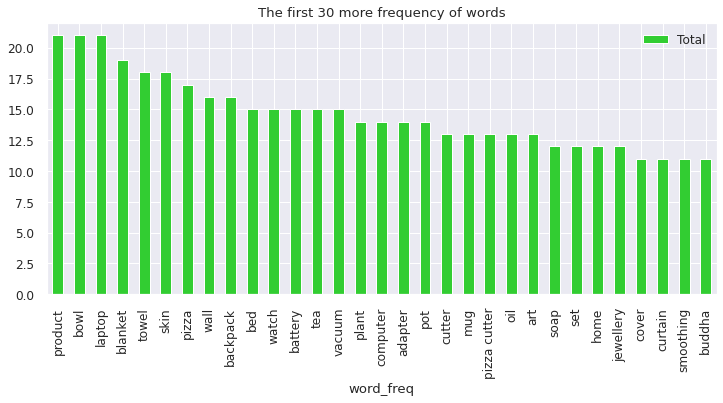

In [ ]:
df1=df_2.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents
df1.plot(kind='bar',x='word_freq',y='Total', color="limegreen",title='The first 30 more frequency of words',figsize=(12,5))

In [ ]:
data['concat']=data['description_short_']+' '+data['name_short_']

In [ ]:
#test
text=data.description[700]
print('#text originale#:',text)
text_modifier=data['description_short_'][700]
print('#text modifié#  :',text_modifier)

#text originale#: Specifications of Vgstore Rectangular Pack of 6 Table Placemat (Dark Blue, PVC) General Brand Vgstore Shape Rectangular Design Code blstri Material PVC Style Code strblue Color Dark Blue In the Box Number of Contents in Sales Package Pack of 6
#text modifié#  : specif vgstore rectangular pack tabl placemat dark blue pvc general brand vgstore shape rectangular design code blstri materi pvc style code strblue color dark blue box number content sale packag pack


In [ ]:
#define vectorizer parameters
from sklearn.feature_extraction.text import CountVectorizer

def BOVW_TF(X,n_gram):
    tfidf_vectorizer = TfidfVectorizer( min_df = 0.01, max_df=0.7, stop_words = 'english', analyzer="word", token_pattern=r'\w+',  ngram_range=n_gram)
    tf_vectorizer= CountVectorizer( min_df = 0.01,  max_df=0.7,stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=n_gram)
    # Generate matrix of word vectors
    # tf-idf (term frequency-inverse document frequency)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X)
    tfidf_words = tfidf_vectorizer.get_feature_names()

    # bag of words (term frequency)
    tf_matrix=tf_vectorizer.fit_transform(X)
    tf_words = tf_vectorizer.get_feature_names()

    return tfidf_matrix,tf_matrix

In [ ]:
data['concat']=data['description_clean']+' '+data['name_clean']

tfidf_matrix_N,  tf_matrix_N = BOVW_TF(data['name_clean'].copy(),n_gram=(1,2))
tfidf_matrix_NF,  tf_matrix_NF = BOVW_TF(data['name_short_'].copy(),n_gram=(1,2))

tfidf_matrix_D,  tf_matrix_D = BOVW_TF(data['description_clean'].copy(),n_gram=(1,1))
tfidf_matrix_DF,  tf_matrix_DF = BOVW_TF(data['description_short_'].copy(),n_gram=(1,1))

#uni & bi
tfidf_matrix_D_b,  tf_matrix_D_b  =  BOVW_TF(data['description_clean'].copy(),n_gram=(1,2))
tfidf_matrix_DF_b,  tf_matrix_DF_b =  BOVW_TF(data['description_short_'].copy(),n_gram=(1,2))

In [ ]:
# clean & unigram
print(tf_matrix_D.shape)
print(tfidf_matrix_D.shape)

(1050, 476)
(1050, 476)


In [ ]:
# final & unigram
print(tf_matrix_DF.shape)
print(tfidf_matrix_DF.shape)

(1050, 452)
(1050, 452)


In [ ]:
# final & unigram & bigram
print(tf_matrix_DF_b.shape)
print(tfidf_matrix_DF_b.shape)

(1050, 829)
(1050, 829)


In [ ]:
# clean & unigram & bigram
print(tf_matrix_D_b.shape)
print(tfidf_matrix_D_b.shape)

(1050, 876)
(1050, 876)


### **Dimentional reduction**

In [ ]:
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE

def plot_tsne_pca(matrix,title,labels):

# Dimensionality reduction using PCA,
     # reduce the tfidf matrix to just 2 features

    pca = PCA(n_components=2, random_state=5).fit_transform(matrix)
    tsne_pca = TSNE().fit_transform(PCA(n_components=3).fit_transform(matrix))
    tsne = TSNE(n_components=2, random_state=5).fit_transform(matrix)

    #attaching the label to each 2D projection
    pca_data=np.vstack((pca.T,labels)).T
    pca_df=pd.DataFrame(pca_data, columns=['pca-one','pca-two','category'])

    tsne_data=np.vstack((tsne.T,labels)).T
    tsne_df=pd.DataFrame(tsne_data, columns=['tsne-one','tsne-two','category'])


    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)

    f, ax = plt.subplots(1, 2, figsize=(18, 6))

    sns.scatterplot(data=pca_df, x="pca-one", y="pca-two",
                    hue='category', ax=ax[0])

    ax[0].set_title('PCA Cluster Plot'+' '+title)

    sns.scatterplot(data=tsne_df, x="tsne-one", y="tsne-two",
                    hue='category', ax=ax[1])

    ax[1].set_title('TSNE Cluster Plot'+' '+title)

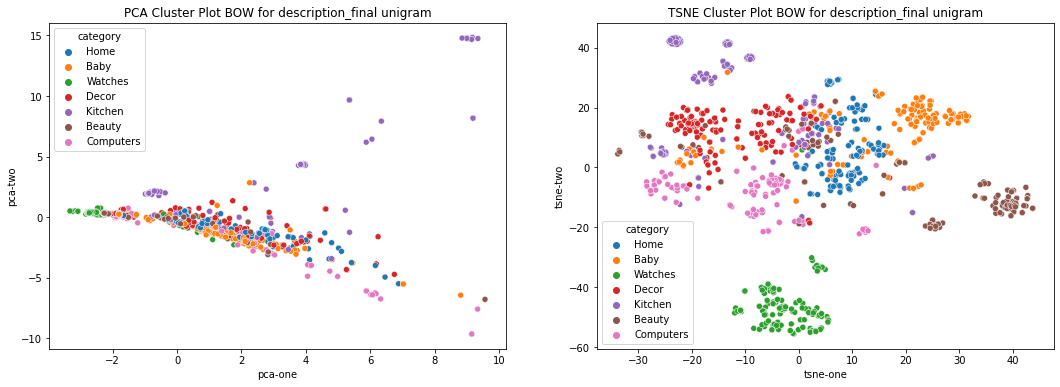

In [ ]:
plot_tsne_pca(tf_matrix_DF.todense(),'BOW_vec for description_final unigram',data['category'])

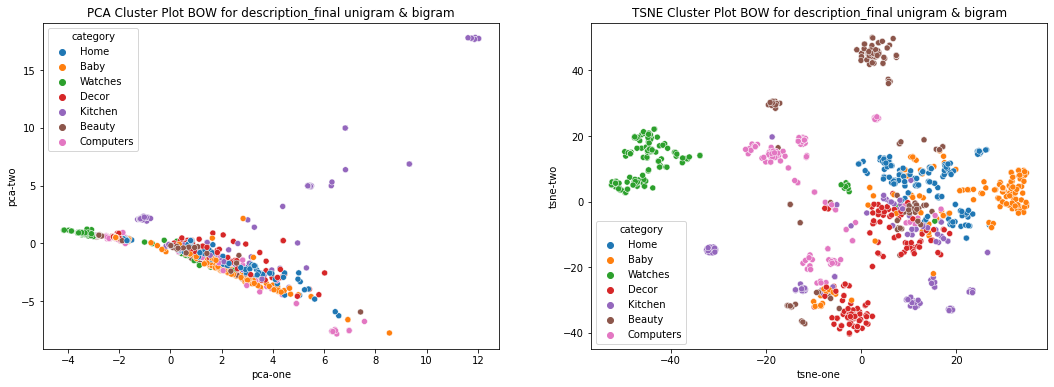

In [ ]:
plot_tsne_pca(tf_matrix_DF_b.todense(),'BOW_vec for description_final unigram & bigram',data['category'])

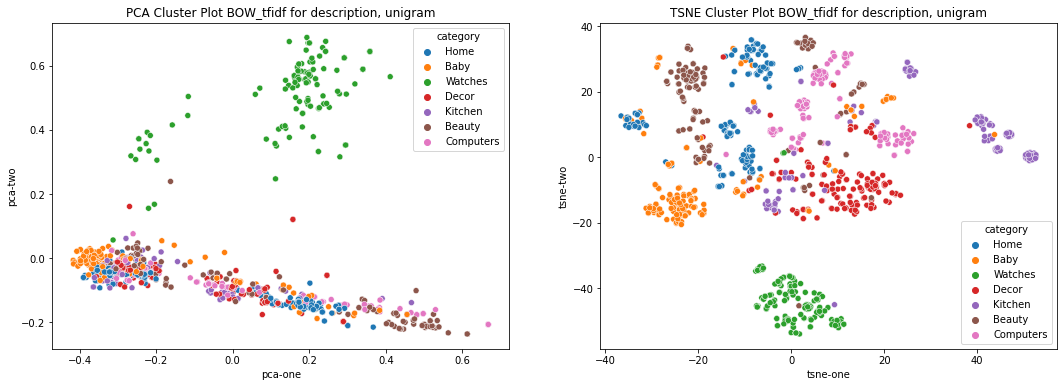

In [ ]:
plot_tsne_pca(tfidf_matrix_DF.todense(),'BOW_tfidf for description, unigram',data['category'])

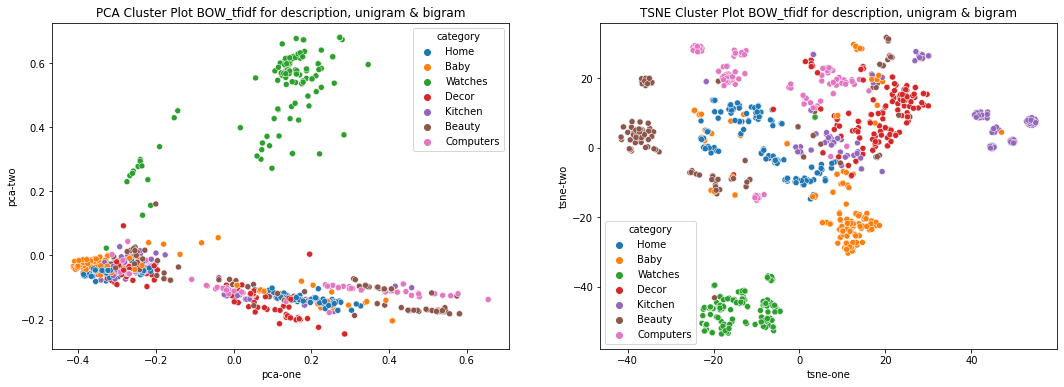

In [ ]:
plot_tsne_pca(tfidf_matrix_DF_b.todense(),'BOW_tfidf for description, unigram & bigram',data['category'])

## Word2Vec

Word2Vec (W2V) is an algorithm that accepts text corpus as an input and outputs a vector representation for each word

https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import tokenize
sentence = [list(tokenize(s, deacc=True, lower=True)) for s in data['description_short_']]
print(sentence[350])
model = Word2Vec(sentence, min_count=500,)
model.corpus_count

['buy', 'tplink', 'wireless', 'nano', 'router', 'flipkart', 'com', 'genuin', 'product', 'day', 'replac', 'guarante', 'free', 'ship', 'cash', 'deliveri']


1050

In [ ]:
from gensim.models import Word2Vec
sentences = [list(tokenize(s, deacc=True, lower=True)) for s in data['description_short_']]

# Model
model = Word2Vec(sentences, min_count=15, size=10)
print('model:',model)
print('')

# Vocabulaire
words = list(model.wv.vocab)
print('words:',words)


model: Word2Vec(vocab=612, size=10, alpha=0.025)

words: ['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'height', 'pack', 'price', 'enhanc', 'look', 'interior', 'made', 'high', 'qualiti', 'fabric', 'style', 'metal', 'make', 'room', 'love', 'give', 'home', 'bright', 'design', 'sure', 'smooth', 'morn', 'good', 'world', 'even', 'creat', 'special', 'beauti', 'print', 'bring', 'soft', 'light', 'get', 'right', 'specif', 'general', 'brand', 'type', 'model', 'name', 'set', 'color', 'dimens', 'length', 'box', 'number', 'content', 'sale', 'packag', 'bodi', 'materi', 'cotton', 'bath', 'towel', 'red', 'yellow', 'blue', 'machin', 'washabl', 'yes', 'self', 'gsm', 'ideal', 'men', 'woman', 'boy', 'girl', 'size', 'inch', 'width', 'face', 'small', 'piec', 'exclus', 'export', 'product', 'care', 'skin', 'feel', 'last', 'year', 'fine', 'absorb', 'durabl', 'note', 'may', 'vari', 'pictur', 'wash', 'cold', 'water', 'iron', 'bleach', 'flat', 'dri', 'use', 

In [ ]:
word_ = 'color'

# Vecteur pour un mot
print(model[word_])

[-0.14044206  0.2911864  -0.36384088  0.8951901  -1.5277092   0.7566828
 -0.08993955 -0.63194036 -1.342172   -0.27779576]


In [ ]:
model.most_similar(word_, topn=10)

[('bodi', 0.9923173785209656),
 ('leg', 0.9864658117294312),
 ('polyest', 0.9834884405136108),
 ('half', 0.9833611249923706),
 ('machin', 0.9819052219390869),
 ('regular', 0.9816858172416687),
 ('yes', 0.9803219437599182),
 ('pot', 0.9776343107223511),
 ('addit', 0.9775291681289673),
 ('name', 0.9770057201385498)]

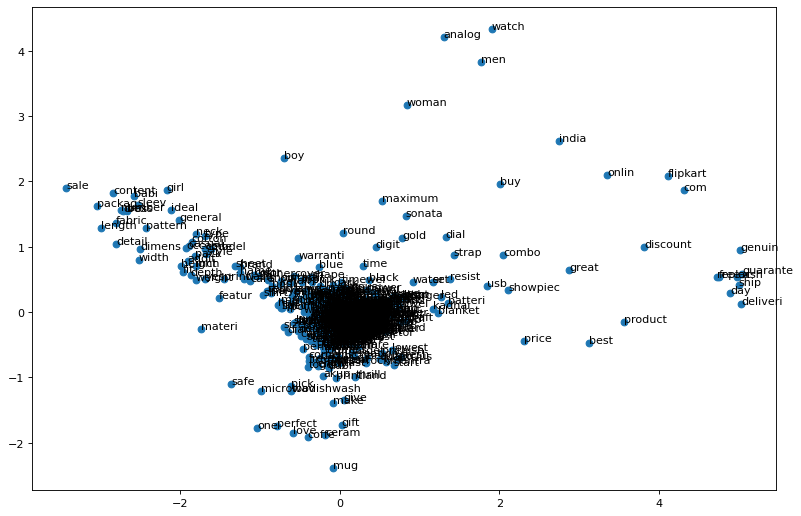

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')


X = model[model.wv.vocab]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Figure
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

In [ ]:
X.shape

(612, 10)

## Modeling

In [ ]:
#W2V
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
  nbw= len(phrase.split())
  return sum(get_vect(w, model) for w in phrase)/nbw



def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

#X_emb_N = word2vec_features(data['name_clean'].copy(), model)
#X_emb_NF = word2vec_features(data['name_fin'].copy(), model)

X_emb_DF = word2vec_features(data['description_short_'].copy(), model)

X_emb_DF.shape

(1050, 10)

Non-Negative Matrix Factorization (**NMF**). ... This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

**LDA** ( short for Latent Dirichlet Allocation ) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic. A topic is represented as a weighted list of words

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

**SVD** (Singular Value Decomposition) is a widely used technique to decompose a matrix into several component matrices, exposing many of the useful and interesting properties of the original matrix.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [ ]:
k=7#nbr of cluster
def kmeans_clustering(tfidf_matrix,tf_matrix,X_emb,k):

    #Non-Negative Matrix Factorization (NMF)
    nmf = NMF(n_components=k, random_state=24, )
    nmf_matrix = nmf.fit_transform(tfidf_matrix_DF)

 # Latent Dirichlet Allocation
    lda = LatentDirichletAllocation(k, max_iter=5, learning_method='online',learning_offset=50.,random_state=24,)
    lda_tf = lda.fit_transform(tf_matrix_DF)

    # Singular Value Decomposition
    svd = TruncatedSVD(n_components=100)

    svd_tfidf = svd.fit_transform(tfidf_matrix_DF)
    svd_tf = svd.fit_transform(tf_matrix_DF)


    km_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(tfidf_matrix_DF)
    km_tf = KMeans(n_clusters = k,init = 'random', n_init = 50, random_state = 24, algorithm = 'full').fit(tf_matrix_DF)

    km_nmf =KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24 , algorithm = 'full').fit(nmf_matrix)
    km_lda = KMeans(n_clusters = k,init = 'random', n_init = 50, random_state = 24, algorithm = 'full').fit(lda_tf)

    km_svd_tf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tfidf)# svd-based k-means
    km_svd_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tf)

    km_emb = KMeans(n_clusters = k,init = 'random', n_init = 50, random_state = 24, algorithm = 'full').fit(X_emb)   # embr based k-means

    return nmf_matrix, lda_tf, km_tfidf, km_tf, km_nmf, km_svd_tf, km_svd_tfidf, km_lda,km_emb

In [ ]:
#nmf_matrix_N, lda_tf_N, km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N=kmeans_clustering(tfidf_matrix_1,tf_matrix_1,X_emb_N,k=7)
#nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF=kmeans_clustering(tfidf_matrix_2,tf_matrix_2 ,X_emb_NF,k=7)

In [ ]:

lda = LatentDirichletAllocation(7, max_iter=5, learning_method='online',learning_offset=50.,random_state=24,)
lda_tf = lda.fit_transform(tf_matrix_DF)
lda_tf


array([[0.00137854, 0.06403937, 0.00137609, ..., 0.0013747 , 0.92907762,
        0.00137731],
       [0.00260003, 0.00260058, 0.00260425, ..., 0.00260498, 0.22489684,
        0.76209269],
       [0.05997294, 0.00129488, 0.01985392, ..., 0.00129127, 0.44643651,
        0.46985705],
       ...,
       [0.30704831, 0.00714565, 0.00715268, ..., 0.6572175 , 0.00714484,
        0.00714428],
       [0.41124472, 0.00649596, 0.00649707, ..., 0.55627549, 0.00649523,
        0.00649476],
       [0.34337904, 0.00714573, 0.00714807, ..., 0.62089132, 0.00714482,
        0.00714425]])

In [ ]:
lda_tf_DF

array([[0.00137854, 0.06403937, 0.00137609, ..., 0.0013747 , 0.92907762,
        0.00137731],
       [0.00260003, 0.00260058, 0.00260425, ..., 0.00260498, 0.22489684,
        0.76209269],
       [0.05997294, 0.00129488, 0.01985392, ..., 0.00129127, 0.44643651,
        0.46985705],
       ...,
       [0.30704831, 0.00714565, 0.00715268, ..., 0.6572175 , 0.00714484,
        0.00714428],
       [0.41124472, 0.00649596, 0.00649707, ..., 0.55627549, 0.00649523,
        0.00649476],
       [0.34337904, 0.00714573, 0.00714807, ..., 0.62089132, 0.00714482,
        0.00714425]])

In [ ]:
# unigram
nmf_matrix_D,  lda_tf_D,  km_tfidf_D,  km_tf_D,  km_nmf_D,  km_lda_D,  km_svd_tf_D,  km_svd_tfidf_D, km_emb_D  =  kmeans_clustering(tfidf_matrix_D,tf_matrix_D,X_emb_D,k=7)
nmf_matrix_DF, lda_tf_DF, km_tfidf_DF, km_tf_DF, km_nmf_DF, km_lda_DF, km_svd_tf_DF, km_svd_tfidf_DF, km_emb_DF = kmeans_clustering(tfidf_matrix_DF,tf_matrix_DF,X_emb_DF,k=7)

NameError: ignored

In [ ]:
# uni & bigram
nmf_matrix_D_b,  lda_tf_D_b,  km_tfidf_D_b,  km_tf_D_b,  km_nmf_D_b,  km_lda_D_b,  km_svd_tf_D_b,  km_svd_tfidf_D_b, km_emb_D_b  =  kmeans_clustering(tfidf_matrix_D_b,tf_matrix_D_b,X_emb_D,k=7)
nmf_matrix_DF_b, lda_tf_DF_b, km_tfidf_DF_b, km_tf_DF_b, km_nmf_DF_b, km_lda_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b, km_emb_DF_b = kmeans_clustering(tfidf_matrix_DF_b,tf_matrix_DF_b,X_emb_DF,k=7)

In [ ]:
def data_cluster(nmf_matrix, lda_tf, km_tfidf, km_tf, km_nmf, km_lda, km_svd_tf, km_svd_tfidf, km_emb):
  df = pd.DataFrame(columns=['cluster_nmf',
                            'cluster_lda',
                            'cluster_nmf_km',
                            'cluster_lda_km',
                            'cluster_svd_tfidf',
                            'cluster_svd_tf',
                            'cluster_emb',
                            'cluster_tfidf',
                            'cluster_tf',], index=range(1050))
  df['cluster_nmf']=pd.DataFrame(nmf_matrix).idxmax(axis = 1)
  df['cluster_lda']=pd.DataFrame(lda_tf).idxmax(axis = 1)
  df['cluster_nmf_km']=km_nmf.labels_
  df['cluster_lda_km']=km_lda.labels_
  df['cluster_svd_tfidf']=km_svd_tfidf.labels_
  df['cluster_svd_tf']=km_svd_tf.labels_
  df['cluster_emb']=km_emb.labels_
  df['cluster_tfidf']=km_tfidf.labels_
  df['cluster_tf']=km_tf.labels_
  return df

In [ ]:
# uni

#df_name=data_cluster(nmf_matrix_N,lda_tf_N,km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N)
#df_name_final=data_cluster(nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF)

df_desc_vec_u  = data_cluster(nmf_matrix_D, lda_tf_D, km_tfidf_D, km_tf_D, km_nmf_D, km_lda_D, km_svd_tf_D, km_svd_tfidf_D, km_emb_D)
df_desc_tfidf_u= data_cluster(nmf_matrix_DF, lda_tf_DF, km_tfidf_DF, km_tf_DF, km_nmf_DF, km_lda_DF, km_svd_tf_DF, km_svd_tfidf_DF, km_emb_DF)

In [ ]:
# uni & bi
df_desc_vec_ub  = data_cluster(nmf_matrix_D_b,  lda_tf_D_b,  km_tfidf_D_b,  km_tf_D_b,  km_nmf_D_b,  km_lda_D_b,  km_svd_tf_D_b,  km_svd_tfidf_D_b, km_emb_D_b)
df_desc_tfidf_ub= data_cluster(nmf_matrix_DF_b, lda_tf_DF_b, km_tfidf_DF_b, km_tf_DF_b, km_nmf_DF_b, km_lda_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b, km_emb_DF_b)

In [ ]:
def Ari_score (df,label,label_tru):
  cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

  # Prep
  k_labels = df[label].map(cluster)  # Get cluster labels
  k_labels_matched = np.empty_like(k_labels)

  # For each cluster label...
  for k in np.unique(k_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(label_tru==t)) for t in np.unique(label_tru)]
    k_labels_matched[k_labels==k] = np.unique(label_tru)[np.argmax(match_nums)]
  #confusion_matrix
  conf_mat = confusion_matrix(label_tru, k_labels_matched)

  #compute ARI SCORE
  ari_score=adjusted_rand_score(label_tru, k_labels_matched)
  homogeneity=homogeneity_score(label_tru, k_labels_matched)

  return ari_score,homogeneity

In [ ]:
def data_ari(df,Title):
    liste=['cluster_nmf','cluster_lda','cluster_nmf_km','cluster_lda_km',
          'cluster_svd_tfidf','cluster_svd_tf','cluster_emb','cluster_tfidf',
          'cluster_tf']

    ARI=[]
    for cluster in liste:
      ari,homg=Ari_score (df,cluster, data['category'])
      ARI.append([ari,homg])


    df_ari=pd.DataFrame(ARI
                        ,index=['cluster_nmf','cluster_lda',
                        'nmf_km','lda_km',
                        'svd_tfidf_km','svd_tf_km',
                        'emb_km',
                        'tfidf_km',
                        'tf_km'],
                        columns=['ARI_SCORE','Homogeneity_score'])


    #display scores of  each Scaler

    tab_score=df_ari.round(3)

    #plot bar each Scaler
    barWidth = 0.25# the width of the bars

    r1 = np.arange(len(tab_score))
    r2 = [x + barWidth for x in r1]
    fig, ax = plt.subplots(figsize=(16,7))

    rec1=ax.bar(r1,
                tab_score['ARI_SCORE'],
                color='darkorange',
                width=barWidth,
                label='ARI_SCORE')
    rec2=ax.bar(r2,
                tab_score['Homogeneity_score'],
                color='teal',
                width=barWidth,
                label='Homogeneity_score')

    for rect in rec1 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    for rect in rec2 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    # add some text for labels, title and axes ticks
    ax.set_title('Comparaison des performances Kmeans'+' '+Title, fontsize = 20)
    ax.set_xlabel('Models', fontsize = 15)
    ax.set_ylabel('Scores', fontsize = 15)
    ax.set_ylim(top=1)
    plt.xticks(r1, tab_score.index)
    ax.legend()
    plt.show()

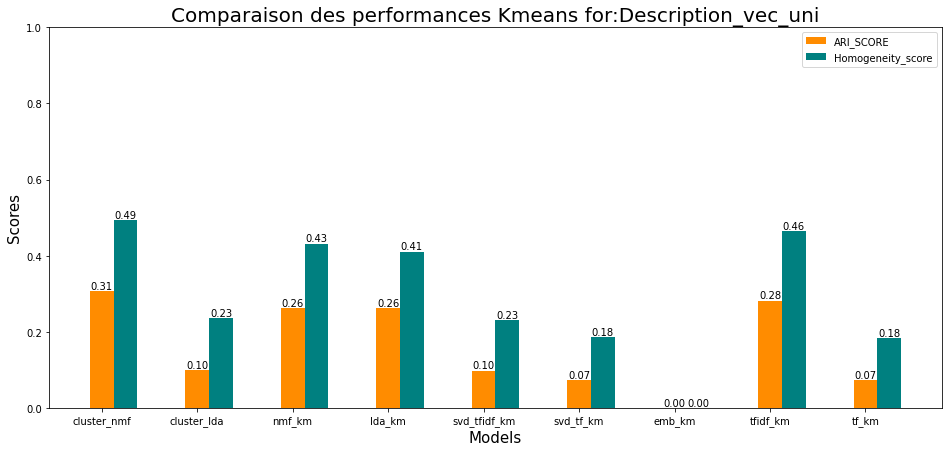

In [ ]:
data_ari(df_desc_vec_u,'for:Description_vec_uni')

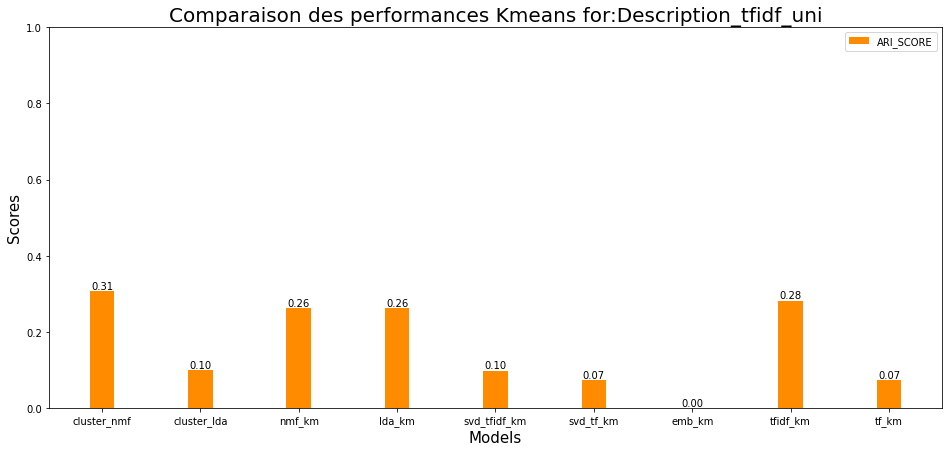

In [ ]:
data_ari(df_desc_tfidf_u,'for:Description_tfidf_uni')

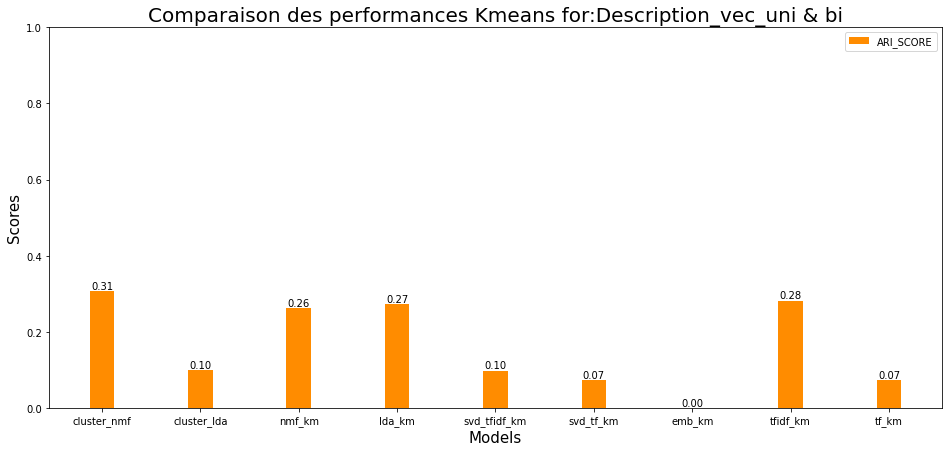

In [ ]:
data_ari(df_desc_vec_ub,'for:Description_vec_uni & bi')

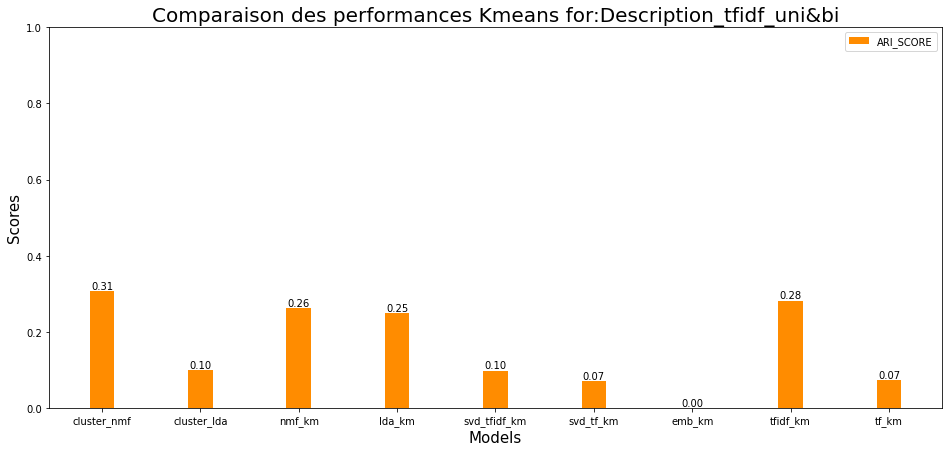

In [ ]:
data_ari(df_desc_tfidf_ub,'for:Description_tfidf_uni&bi')

## **Classification**

### **KMean**

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics, cluster

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(tfidf_matrix_1)   #unigram
visualizer.poof()

NameError: ignored

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(tfidf_matrix_2)   #unigram & bigram
visualizer.poof()

NameError: ignored

In [ ]:
tfidf_matrix_N,tf_matrix_N=BOVW_TF(corpus.copy(),n_gram=(1,2))


In [ ]:
k=7#nbr of cluster
def kmeans_clustering(tfidf_matrix,tf_matrix,k):

    nmf = NMF(n_components=k)
    nmf_matrix = nmf.fit_transform(tfidf_matrix_1)


    lda = LatentDirichletAllocation(k, learning_method='batch')
    lda_tf = lda.fit_transform(tf_matrix_1)

    # Singular Value Decomposition
    lsa = TruncatedSVD(n_components=100)

    matrix1=tfidf_matrix.copy()
    matrix2=tf_matrix.copy()

    lsa_tfidf = lsa.fit_transform(matrix1)
    lsa_tf = lsa.fit_transform(matrix2)
    # initialize standardscaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import Normalizer,MinMaxScaler

    SS = Normalizer()
 # transform my reducer data using standardscaler

    #tfidf=SS.fit_transform(X)
    #tf=SS.fit_transform(Y)
    #lsa_tfidf_std = SS.fit_transform(lsa_matrix_tfidf)
    #lsa_tf_std = SS.fit_transform(lsa_matrix_tf)
    #nmf_tfidf_std = SS.fit_transform(nmf_matrix)
    #lda_tf_std = SS.fit_transform(lda_matrix)
    #X_emb_std=SS.fit_transform(X_emb)
    km_tfidf = KMeans(n_clusters = k,init = 'random'
                          , n_init = 50, random_state = 20
                          , algorithm = 'full').fit(tfidf_matrix_1)
    km_tf = KMeans(n_clusters = k,init = 'random'
                          , n_init = 50, random_state = 20
                          , algorithm = 'full').fit(tf_matrix_1)



    return km_tfidf, km_tf

In [ ]:
km_tfidf_N,km_tf_N  =  kmeans_clustering(tfidf_matrix_N,tf_matrix_N,k=7)
#nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF=kmeans_clustering(tfidf_matrix_NF,tf_matrix_NF,X_emb_NF,k=7)

NameError: ignored

In [ ]:
from sklearn.metrics import make_scorer,adjusted_rand_score
from sklearn.model_selection import GridSearchCV

#nombre de cluster
n_clusters=7

#initier le modèle kmeans avec les parametres defaut
km=KMeans(n_clusters=n_clusters)
#le score à optimiser
score=make_scorer(adjusted_rand_score)
#les hyperparametres à optimiser
parameters = {'init':('k-means++', 'random'),
              'max_iter':[50,100,120],#Nombre de fois où l'algorithme k-means sera exécuté avec différentes valeurs de centroïde. Les résultats finaux seront la meilleure sortie de n_init exécutions consécutives en termes d'inertie.
              'n_init':[5,10,15],#Nombre maximum d'itérations de l'algorithme k-means pour une seule exécution.
              'algorithm':['auto', 'full', 'elkan'],#Algorithme K-means à utiliser
              'random_state': [20,25,30,40,60,]}#Détermine la génération de nombres aléatoires pour l'initialisation du centre de gravité. Utilisez un int pour rendre le caractère aléatoire déterministe

#recherche sur gride

grid = GridSearchCV(km, parameters,scoring=score)
grid.fit(lda_tf,data.category_mo)
index_grid=grid.cv_results_['rank_test_score'].tolist().index(1)
print("ARI score mean :"+str(grid.cv_results_['mean_test_score'][index_grid]))
print("Best parameters: "+str(grid.best_params_))

NameError: ignored

In [ ]:
def Ari_score (df,label,label_tru):
  cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

  # Prep
  k_labels = df[label].map(cluster)  # Get cluster labels
  k_labels_matched = np.empty_like(k_labels)

  # For each cluster label...
  for k in np.unique(k_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(label_tru==t)) for t in np.unique(label_tru)]
    k_labels_matched[k_labels==k] = np.unique(label_tru)[np.argmax(match_nums)]
  #confusion_matrix
  conf_mat = confusion_matrix(label_tru, k_labels_matched)

  #compute ARI SCORE
  ari_score=adjusted_rand_score(label_tru, k_labels_matched)
  homogeneity=homogeneity_score(label_tru, k_labels_matched)

  return ari_score,homogeneity

In [ ]:
def data_ari(df,Title):
    liste=['cluster_nmf','cluster_lda','cluster_nmf_km','cluster_lda_km',
          'cluster_lsa_tfidf','cluster_lsa_tf','cluster_emb','cluster_tfidf',
          'cluster_tf']

    ARI=[]
    for cluster in liste:
      ari,homg=Ari_score (df,cluster,
                            data['category'])
      ARI.append([ari,homg])


    df_ari=pd.DataFrame(ARI
                        ,index=['cluster_nmf','cluster_lda',
                        'nmf_km','lda_km',
                        'lsa_tfidf_km','lsa_tf_km',
                        'emb_km',
                        'tfidf_km',
                        'tf_km'],
                        columns=['ARI_SCORE','Homogeneity_score'])


    #display scores of  each Scaler

    tab_score=df_ari.round(3)

    #plot bar each Scaler
    barWidth = 0.25# the width of the bars

    r1 = np.arange(len(tab_score))
    r2 = [x + barWidth for x in r1]
    fig, ax = plt.subplots(figsize=(12,7))

    rec1=ax.bar(r1,
                tab_score['ARI_SCORE'],
                color='darkorange',
                width=barWidth,
                label='ARI_SCORE')
    rec2=ax.bar(r2,
                tab_score['Homogeneity_score'],
                color='teal',
                width=barWidth,
                label='Homogeneity_score')

    for rect in rec1 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    for rect in rec2 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    # add some text for labels, title and axes ticks
    ax.set_title('Comparaison des performances Kmeans'+' '+Title, fontsize = 20)
    ax.set_xlabel('Models', fontsize = 15)
    ax.set_ylabel('Scores', fontsize = 15)
    ax.set_ylim(top=1)
    plt.xticks(r1, tab_score.index)
    ax.legend()
    plt.show()

In [ ]:
data_ari(df_name_final,'for:Name_Final')

NameError: ignored

In [ ]:
km_model =cluster.KMeans(n_clusters=7,
        init="k-means++",
        random_state = 24,
        n_init=10)

# tfidf_matrix_1 : tfidf_unigram
model_1 = km_model.fit(tfidf_matrix_1)

# tfidf_matrix_2 : tfidf_unigram & bigram
model_2 = km_model.fit(tfidf_matrix_2)

# tf_matrix_1   :  tf_vectorize_unigram
model_3 = km_model.fit(tf_matrix_1)

# tf_matrix_2   :  tf_vectorize_unigram & bigram
model_4 = km_model.fit(tf_matrix_2)

In [ ]:
labels_kmeans_1 = pd.DataFrame(model_1.labels_, columns=['KMC_tfidf_unigram'])
labels_kmeans_2 = pd.DataFrame(model_2.labels_, columns=['KMC_tfidf_bigram'])
labels_kmeans_3 = pd.DataFrame(model_3.labels_, columns=['KMC_tf_vectorize_unigram'])
labels_kmeans_4 = pd.DataFrame(model_4.labels_, columns=['KMC_tf_vectorize_bigram'])

In [ ]:
tot_data_label = pd.concat([text_data['category'], text_data['label_category'], labels_kmeans_1,labels_kmeans_2,labels_kmeans_3,labels_kmeans_4], axis=1)
tot_data_label.tail()

category  label_category  KMC_tfidf_unigram  KMC_tfidf_bigram  \
1045     Baby               0                  2                 2   
1046     Baby               0                  2                 2   
1047     Baby               0                  1                 1   
1048     Baby               0                  1                 1   
1049     Baby               0                  1                 1   

      KMC_tf_vectorize_unigram  KMC_tf_vectorize_bigram  
1045                         2                        2  
1046                         2                        2  
1047                         1                        1  
1048                         1                        1  
1049                         1                        1

In [ ]:
ARI_kmeans_1 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tfidf_unigram'])
ARI_kmeans_2 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tfidf_bigram'])
ARI_kmeans_3 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tf_vectorize_unigram'])
ARI_kmeans_4 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tf_vectorize_bigram'])


In [ ]:
ARI= pd.DataFrame({'columns':['KM_tfidf_unigram','KM_tfidf_bigram','KMC_tf_vectorize_unigram','KMC_tf_vectorize_bigram'],
                   'ARI':[ARI_kmeans_1,ARI_kmeans_2, ARI_kmeans_3, ARI_kmeans_4]})

In [ ]:
ARI

columns       ARI
0          KM_tfidf_unigram  0.064804
1           KM_tfidf_bigram  0.064804
2  KMC_tf_vectorize_unigram  0.064804
3   KMC_tf_vectorize_bigram  0.064804

In [ ]:
ARI

columns       ARI
0          KM_tfidf_unigram  0.166664
1           KM_tfidf_bigram  0.166664
2  KMC_tf_vectorize_unigram  0.166664
3   KMC_tf_vectorize_bigram  0.166664

In [ ]:
ARI= pd.DataFrame({'columns':['KM_tfidf_unigram','KM_tfidf_bigram'],
                   'ARI':[ARI_kmeans_1,ARI_kmeans_2]})

In [ ]:
ARI

columns       ARI
0  KM_tfidf_unigram  0.234981
1   KM_tfidf_bigram  0.234981

In [ ]:
df_X_kmeans = df_X1ts.merge(df_X3ts, left_index=True, right_index=True)
#df_X_kmeans = df_X_kmeans.merge(df_X2ts, left_index=True, right_index=True)

NameError: ignored

In [ ]:
! pip install KPrototypes

In [ ]:
! pip install kmodes

In [ ]:
from kmodes.kprototypes import KPrototypes

In [ ]:
df_X_kpro = df_X_kmeans
df_X_kpro = df_X_kpro.merge(df_X4, left_index=True, right_index=True)
df_X_kpro.head(3)

NameError: ignored

In [ ]:
kpro_cost_ = 1 ###param

if kpro_cost_ == 1:
    cost = []
    for num_clusters in list(range(1,12)):
        kpro = KPrototypes(n_clusters = num_clusters,
                           init = 'Cao',
                           n_init = 1,
                           verbose = 0,
                           random_state = 24)
        kpro.fit_predict(df_X_kpro, categorical=[len(df_X_kpro.columns.tolist())-1])
        cost.append(kpro.cost_)

    with open('kpro_cost', 'wb') as fp:
        pickle.dump(cost, fp)

elif kpro_cost_ == 0:
    with open ('kpro_cost', 'rb') as fp:
        cost = pickle.load(fp)

plt.figure(figsize=(8,5))
plt.plot(cost)
plt.xlabel('Nombre de classes')
plt.ylabel('Coût')
plt.title('K-Prototypes - Mesure du coût par nombre de classes')
plt.show()

NameError: ignored

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics =7
#le nombre de catégories


# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=5,
        learning_method='online',
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf_matrix_1)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=0)

In [ ]:
model_lda = km_model.fit(tfidf_matrix_1)

In [ ]:
labels_model_lda = pd.DataFrame(model_lda.labels_, columns=['lda_tfidf'])

In [ ]:
tot_data_label = pd.concat([tot_data_label,labels_model_lda], axis=1)
tot_data_label.head()

category  label_category  KMC_tfidf_unigram  KMC_tfidf_bigram  \
0     Home               0                  2                 2   
1     Baby               1                  2                 2   
2     Baby               1                  2                 2   
3     Home               0                  2                 2   
4     Home               0                  2                 2   

   KMC_tf_vectorize_unigram  KMC_tf_vectorize_bigram  lda_tfidf  
0                         2                        2          4  
1                         2                        2          4  
2                         2                        2          4  
3                         2                        2          4  
4                         2                        2          4

In [ ]:
ARI_lda = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['lda_tfidf'])
ARI_lda

0.22962618873346055

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.179226
1          KM_tfidf_bigram  0.179226
2  KM_tf_vectorize_unigram  0.179226
3   KM_tf_vectorize_bigram  0.179226
4                      lda  0.229626

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.116624
1          KM_tfidf_bigram  0.116624
2  KM_tf_vectorize_unigram  0.116624
3   KM_tf_vectorize_bigram  0.116624
4                      lda  0.229626

### **Bigram** frequency

https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

https://www.kaggle.com/vpkprasanna/basic-text-cleaning-wordcloud-and-n-gram-analysis

In [ ]:
def baigram_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
bigram = baigram_clean(''.join(str(text_data['description_final_1'].tolist())))

In [ ]:
description_bigrams_series = (pd.Series(nltk.ngrams(bigram, 2)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

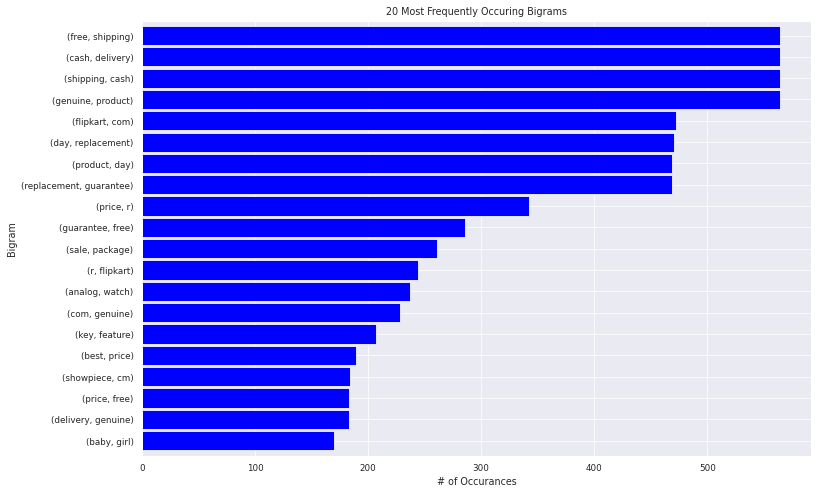

In [ ]:
description_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
description_bigrams_series

(free, shipping)            564
(cash, delivery)            564
(shipping, cash)            564
(genuine, product)          564
(flipkart, com)             472
(day, replacement)          471
(product, day)              469
(replacement, guarantee)    469
(price, r)                  342
(guarantee, free)           286
(sale, package)             261
(r, flipkart)               244
(analog, watch)             237
(com, genuine)              228
(key, feature)              207
(best, price)               189
(showpiece, cm)             184
(delivery, genuine)         183
(price, free)               183
(baby, girl)                170
dtype: int64

### **Word2vec**

Each word's **TF-IDF** relevance is a normalized data format that also adds up to one. ... The main difference is that **Word2vec** produces one vector per word, whereas BoW produces one number (a wordcount). Word2vec is great for digging into documents and identifying content and subsets of content.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
sentences = text_data['description_final_1']
sentences.sample(5)

268    ['buy', 'mom', 'wheel', 'pizza', 'cutter', 'on...
897    ['nkp', 'cotton', 'hand', 'towel', 'hand', 'to...
920    ['buy', 'baby', 'bucket', 'cartoon', 'single',...
729    ['key', 'feature', 'vrct', 'inch', 'green', 'r...
669    ['buy', 'trader', 'cotton', 'bath', 'towel', '...
Name: description_final_1, dtype: object

In [ ]:
from gensim.models import word2vec
model = Word2Vec.Word2Vec(sentences, size=300, window=20, min_count=2)
model.corpus_count

NameError: ignored

In [ ]:
vocab = model.wv.vocab
list(vocab)[:5]

['[', "'", 'k', 'e', 'y']

In [ ]:
from gensim.models import Word2Vec

# On entraîne le modèle
X= text_data['description_final_1']
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X]
model = Word2Vec(sentences, min_count=1, size=10)
print('model:',model)
print('')

# Vocabulaire
words = list(model.wv.vocab)
print('words:',words)
print('')

print(model)

model: Word2Vec(vocab=31, size=10, alpha=0.025)

words: ['[', "'", 'k', 'e', 'y', ',', ' ', 'f', 'a', 't', 'u', 'r', 'l', 'g', 'n', 'c', 'p', 'o', 's', 'm', 'i', 'b', 'd', 'h', 'q', 'v', 'w', 'x', ']', 'z', 'j']

Word2Vec(vocab=31, size=10, alpha=0.025)


In [ ]:
from gensim.models import Word2Vec
from gensim.utils import tokenize

X= text_data['description_final_1']
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X]
print(sentance[0])
model = Word2Vec(sentance, min_count=1,)
model.corpus_count

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'attention', 'sure', 'heart', 'contemporary', 'eyelet', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moment', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'specification', 'elegance', 'polyester', 'multicolor', 'abstract', 

1050

In [ ]:
model

In [ ]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats


X_emb_DF = word2vec_features(text_data['description_final_1'].copy(), model)

X_emb_DF.shape

(1050, 100)

In [ ]:
model_w2v = km_model.fit(X_emb_DF)

In [ ]:
labels_model_w2v = pd.DataFrame(model_w2v.labels_, columns=['model_w2v'])

In [ ]:
tot_data_label = pd.concat([tot_data_label,labels_model_w2v], axis=1)
tot_data_label.head()

NameError: ignored

In [ ]:
tot_data_label['model_w2v'].unique()

array([0], dtype=int32)

In [ ]:
ARI_lda = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['lda_tfidf'])
ARI_lda

0.22962618873346055

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.116624
1          KM_tfidf_bigram  0.116624
2  KM_tf_vectorize_unigram  0.116624
3   KM_tf_vectorize_bigram  0.116624
4                      lda  0.229626

In [ ]:
idex=694


from PIL import Image
from random import *

path = "/content/drive/MyDrive/p6/image/"
im = Image.open(path+flipkart.image[idex])

plt.figure(figsize=(7,7))
plt.imshow(im)

## Traitement des images

In [ ]:
from PIL import Image, ImageOps
ima_id = '0ae859a69c7608d8197c3ba8c37bc6ec'
# Chargement de l'image en mémoire
img0 = Image.open('/content/drive/MyDrive/p6/image/'+ima_id+'.jpg')

# Sauvegarde de l'image sur le disque dans le répertoire images_processed
img0.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_0.jpg', 'jpeg')

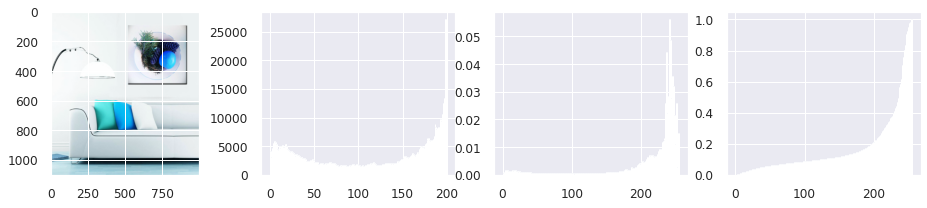

In [ ]:
# Transformation de l'image en matrice de pixels
img0_num = np.array(img0)

# Histogrammes
plt.figure(figsize=(16,3))
plt.subplot(141),plt.imshow(img0)
plt.subplot(142),plt.hist(img0_num.flatten(), bins=range(256)) # Histogramme
plt.subplot(143),plt.hist(img0_num.flatten(), bins=range(256), density=True) # Histogramme normalisé
plt.subplot(144),plt.hist(img0_num.flatten(), bins=range(256), density=True, cumulative=True) # Histogramme normalisé cumulé
plt.show()

In [ ]:
gray_ = 1

if gray_ == 1:
    img1 = img0.convert('L')
elif gray_ == 0:
    img1 = img0

In [ ]:
img1_num = np.array(img1)
img1.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_1.jpg', 'jpeg')

In [ ]:
from PIL import ImageFilter

# Lissage par moyennage (fenêtre de taille 9)
img2a = img1.filter(ImageFilter.BoxBlur(1))
img2a_num = np.array(img2a)
img2a.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_2a.jpg', 'jpeg')

In [ ]:
# Filtre gaussien
img2b = img1.filter(ImageFilter.GaussianBlur(1))
img2b_num = np.array(img2b)
img2b.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_2b.jpg', 'jpeg')

In [ ]:
# Egalisation après réduction de bruit méthode 1
img3a = ImageOps.equalize(img2a, mask = None)
img3a_num = np.array(img3a)
img3a.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_3a.jpg', 'jpeg')

In [ ]:
# Egalisation après réduction de bruit méthode 2
img3b = ImageOps.equalize(img2b, mask = None)
img3b_num = np.array(img3b)
img3b.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_3b.jpg', 'jpeg')

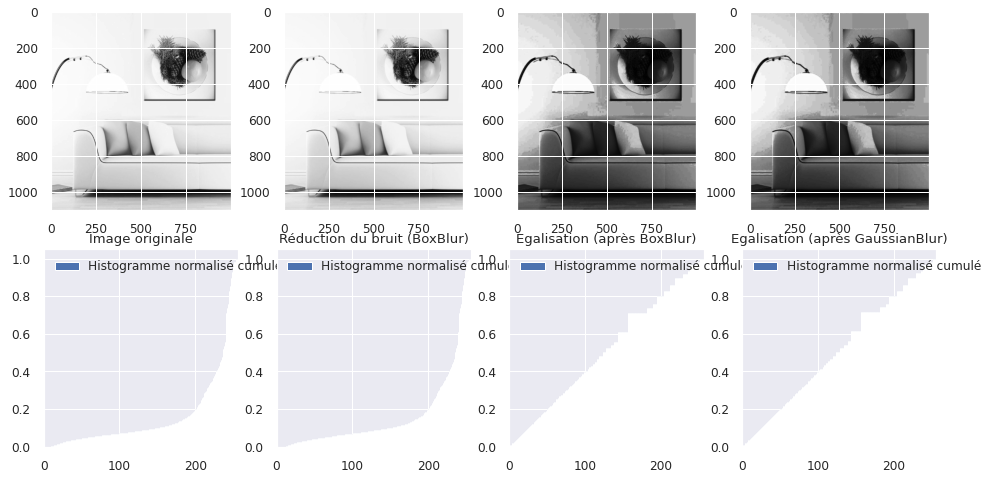

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(241),plt.imshow(img1, cmap='gray')
plt.subplot(242),plt.imshow(img2a, cmap='gray')
plt.subplot(243),plt.imshow(img3a, cmap='gray')
plt.subplot(244),plt.imshow(img3b, cmap='gray')

plt.subplot(245),plt.hist(img1_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Image originale')

plt.subplot(246),plt.hist(img2a_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Réduction du bruit (BoxBlur)')

plt.subplot(247),plt.hist(img3a_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Egalisation (après BoxBlur)')

plt.subplot(248),plt.hist(img3b_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Egalisation (après GaussianBlur)')

plt.show()

Prétraitement des images avec OpenCV

In [ ]:
import cv2
print('cv2',cv2.__version__)

cv2 4.1.2


In [ ]:
img0 = cv2.imread('/content/drive/MyDrive/p6/image/'+ima_id+'.jpg') # On charge l'image en couleur en mémoire

In [ ]:
gray_ = 0

if gray_ == 1:
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY) # Conversion de l'image originale (couleur) en niveaux de gris

    # Format d'affichage:
      # L'image sera affichée en niveaux de gris inversés, on la redressera avec le paramètre cmap='gray'
    img1_ = img1

elif gray_ == 0:
    img1 = img0 # Image en couleur

    # Format d'affichage:
      # cv2 traite les images en mode BGR
      # Le processus de traitement d'une image native RGB se fait donc en mode BGR
      # L'image traitée sauvegardée sur disque sera rendue dans le format original, donc RGB
      # Par contre, l'affiche de l'image en cours de processus sera exécuté en mode BGR
      # Il est donc nécessaire d'ajouter une étape préliminaire à l'affichage avec la méthode cvtcolor

    img1_ = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Transformation BGR --> RGB

In [ ]:
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_1.jpg', img1) # On sauvegarde l'image sur le disque
                                                                          # dans le répertoire images_processed

True

In [ ]:
hist,bins = np.histogram(img1.flatten(),256,[0,256])
cdf1 = hist.cumsum()
cdf1_normalized = cdf1 * hist.max() / cdf1.max()

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_1.jpg')

if gray_ == 1:
    img2 = cv2.fastNlMeansDenoising(img1,None,5,7,21) # Image en niveaux de gris
    img2_ = img2
elif gray_ == 0:
    img2 = cv2.fastNlMeansDenoisingColored(img1,None,5,5,7,21) # Image en BGR
    img2_ = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # Image en RGB (pour affichage)

cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg', img2)

True

In [ ]:
hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf2 = hist.cumsum()
cdf2_normalized = cdf2 * hist.max() / cdf2.max()

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg',0)

img3a = cv2.equalizeHist(img2)
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_3a.jpg', img3a)

# Après égalisation, l'image est rendue en niveaux de gris
# Les niveaux sont inversés à l'affichage
# On utilisera donc le paramètre cmap ='gray' pour rétablir les niveaux

True

In [ ]:
hist,bins = np.histogram(img3a.flatten(),256,[0,256])
cdf3a = hist.cumsum()
cdf3a_normalized = cdf3a * hist.max() / cdf3a.max()

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg',0)

# On créé un objet CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img3b = clahe.apply(img2)
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_3b.jpg', img3b)

True

In [ ]:
hist,bins = np.histogram(img3b.flatten(),256,[0,256])
cdf3b = hist.cumsum()
cdf3b_normalized = cdf3b * hist.max() / cdf3b.max()

Text(0.5, 1.0, 'Egalisation (clahe)')

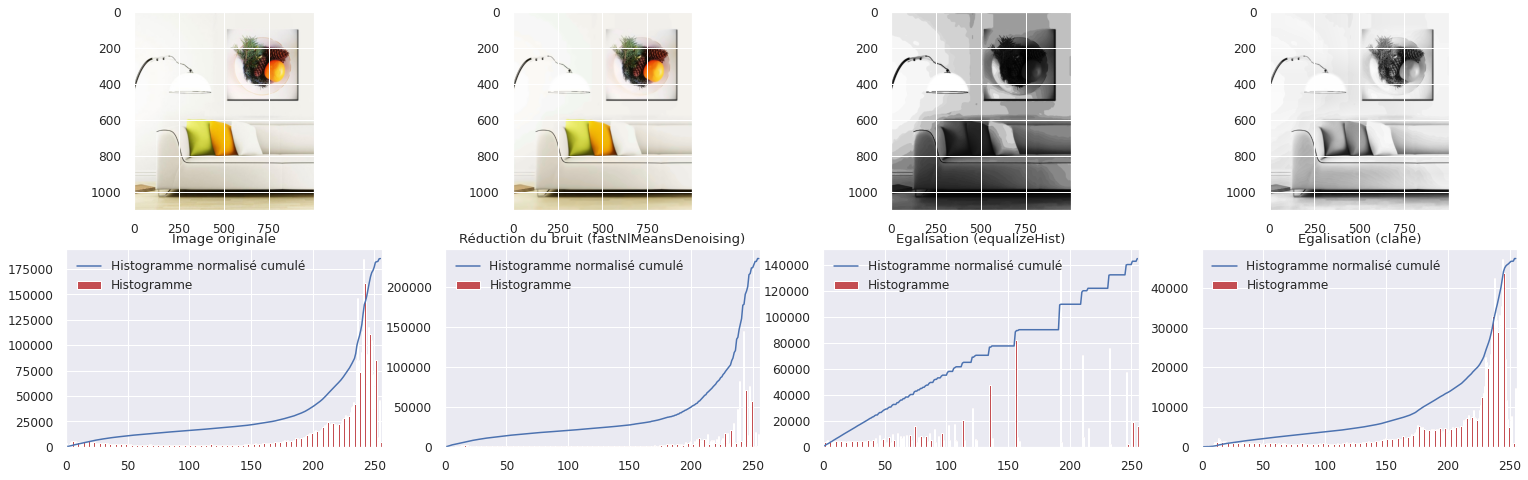

In [ ]:
plt.figure(figsize=(26,8))

if gray_ == 1:
    plt.subplot(241),plt.imshow(img1_, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(242),plt.imshow(img2_)
    plt.subplot(243),plt.imshow(img3a, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(244),plt.imshow(img3b, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap

elif gray_ == 0:
    plt.subplot(241),plt.imshow(img1_) # Image affichée en RGB
    plt.subplot(242),plt.imshow(img2_) # Image affichée en RGB
    plt.subplot(243),plt.imshow(img3a, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(244),plt.imshow(img3b, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap

plt.subplot(245)
plt.plot(cdf1_normalized,color='b')
plt.hist(img1.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Image originale')

plt.subplot(246)
plt.plot(cdf2_normalized,color='b')
plt.hist(img2.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Réduction du bruit (fastNlMeansDenoising)')

plt.subplot(247)
plt.plot(cdf3a_normalized,color='b')
plt.hist(img3a.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Egalisation (equalizeHist)')

plt.subplot(248)
plt.plot(cdf3b_normalized,color='b')
plt.hist(img3b.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Egalisation (clahe)')


In [ ]:
img1_num = np.array(img1)
img1.save('../OCDS_Projet_6/images_processed/'+ima_id+'_A_1.jpg', 'jpeg')